### Imports

In [ ]:
import numpy as np
import h5py
import math
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy import optimize
from scipy.optimize import fsolve
from scipy import spatial

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import spearmanr

from scipy.signal import savgol_filter   

import heapq

import timeit
import glob
from tqdm import tqdm

import os
import pickle
import psutil

from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value

from itertools import zip_longest
import seaborn as sns
import corner

from multiprocessing import Pool, cpu_count

print ("loaded modules")

loaded modules


### Parameters

In [2]:
# File for the z=0 LG data.
LG_data_file = 'new_MiniUchu_data_m200_pos_gravity_IDs_rgrav=5.npz'  # files selected by m200, includes the gravity calculation

LG_tree_file = 'new_MiniUchu_treedata_set.npz'

cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3, Tcmb0=2.725)

hubble = .6774

G = 4300700 # for M in units of 10^12
max_residual = 1e-4 # for the TA solution
bounds = [(1e-2, 2*np.pi)] # bounds on eta for slsqp solver

boxSize = 2000. / hubble * 1000. 

m_min = 5e11  # minimum mass for the haloes at z=0
m_max = 3e12 # maximum mass for the haloes at z=0

# the pamameters below are for the pre-selection of LG analogues. We later define 'broad' and 'strict' subsets.

r_gravity = 5000. # this is the radius within which we look for haloes that dominate the gravitational force.
r_limit = 2000. # this is the radius within which we want no third object
r_max = 1000. # this is the maximum separation between the MW and M31.
r_min = 500. # this is the minimum separation between the MW and M31.
vr_max = -50
vr_min = -150
vt_max = 100
vt_min = 0

# These are the selection criteria we use later for the 'broad' and 'strict' subsets.
r_min_strict = .77 - .15
r_max_strict = .77 + .15
vr_min_strict = -110 - 30
vr_max_strict = -110 + 30
vt_max_strict = 60

r_min_broad = .77 - .3
r_max_broad = .77 + .3
vr_min_broad = -110 - 90
vr_max_broad = -110 + 90
vt_max_broad = 150  

snapshots = np.array([50,45,40,30,20,15,12])
particle_index = np.arange(0,len(snapshots))   # for indexing the particle data
tree_index = 50 - snapshots                    # for indexing the tree data

fine_index = np.arange(0,max(tree_index)+1)

print ("tree indices:", tree_index, "particle indices:", particle_index)
print ("fine index:", fine_index)

# ages to display
ages = np.array([13, 10, 8, 6, 5, 4, 3, 2, 1])*u.Gyr
ageticks = [1 / (1 + z_at_value(cosmo.age, age)) for age in ages]

# redshifts to display 
label_redshifts = np.array([4,3,2,1,0.5,0.2,0])
label_redshifts_str = ["4","3","2","1","0.5","0.2","0"]
label_scales = 1 / (label_redshifts + 1)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"


m_min_gravity = 0.2e12 # consider perturbers above 2 x 10^11

N_volumes = 1 # For Mini-Uchuu, there is only one file

num_process = 4

basePath = '/scratch/project_2010958/uchuu_catalogues/skun.iaa.csic.es/SUsimulations/UchuuDR1/Uchuu/RockstarExtendedM200c1e11/halodir_050/'

tree indices: [ 0  5 10 20 30 35 38] particle indices: [0 1 2 3 4 5 6]
fine index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


## Loading data saved by running prepare_data.ipynb and prepare_data_without_pairs.ipynb

### Mass data

In [3]:
data_LG = np.load("MW_M31_in_LG_mass_stats.npz")
data_no_LG = np.load("MW_M31_no_LG_mass_stats.npz")

scale = data_LG["scale"]

mass_data = {
    "LG":{
        "MW":{
            "m": data_LG["m_MW"],
            "norm": data_LG["m_MW_norm"],
            "med": data_LG["m_MW_med"],
            "plus1": data_LG["m_MW_plus1"],
            "minus1": data_LG["m_MW_minus1"],
            "med_norm": data_LG["m_MW_med_norm"],
            "plus1_norm": data_LG["m_MW_plus1_norm"],
            "minus1_norm": data_LG["m_MW_minus1_norm"]
        },
        "M31":{
            "m": data_LG["m_M31"],
            "norm": data_LG["m_M31_norm"],
            "med": data_LG["m_M31_med"],
            "plus1": data_LG["m_M31_plus1"],
            "minus1": data_LG["m_M31_minus1"],
            "med_norm": data_LG["m_M31_med_norm"],
            "plus1_norm": data_LG["m_M31_plus1_norm"],
            "minus1_norm": data_LG["m_M31_minus1_norm"]
        }
    },
    "no_LG":{
        "MW":{
            "m": data_no_LG["m_MW"],
            "norm": data_no_LG["m_MW_norm"],
            "med": data_no_LG["m_MW_med"],
            "plus1": data_no_LG["m_MW_plus1"],
            "minus1": data_no_LG["m_MW_minus1"],
            "med_norm": data_no_LG["m_MW_med_norm"],
            "plus1_norm": data_no_LG["m_MW_plus1_norm"],
            "minus1_norm": data_no_LG["m_MW_minus1_norm"]
        },
        "M31":{
            "m": data_no_LG["m_M31"],
            "norm": data_no_LG["m_M31_norm"],
            "med": data_no_LG["m_M31_med"],
            "plus1": data_no_LG["m_M31_plus1"],
            "minus1": data_no_LG["m_M31_minus1"],
            "med_norm": data_no_LG["m_M31_med_norm"],
            "plus1_norm": data_no_LG["m_M31_plus1_norm"],
            "minus1_norm": data_no_LG["m_M31_minus1_norm"]
        }
    }
}

print("loaded data.")

loaded data.


### Environment data + selection only z=0

In [4]:
with np.load('orbits_savgol.npz', allow_pickle=True) as calculationdata:
    list_M_TA = calculationdata['list_M_TA']
    list_a_TA = calculationdata['list_a_TA']
    list_e_TA = calculationdata['list_e_TA']
    list_eta_TA = calculationdata['list_eta_TA']
    list_solver_TA = calculationdata['list_solver_TA']
    list_r = calculationdata['list_r']
    list_vr = calculationdata['list_vr']
    list_vt = calculationdata['list_vt']
    list_M_MW = calculationdata['list_M_MW']
    list_M_M31 = calculationdata['list_M_M31']
    list_N_prog = calculationdata['list_N_prog']
    selection_orbits = calculationdata['selection']
    list_index_MW = calculationdata['list_index_MW']
    list_index_M31 = calculationdata['list_index_M31']


#correction pour avoir les bons r, vr, vt
with np.load('z0_data_r_vr_vt.npz', allow_pickle = True) as calculationdata:
    r = calculationdata['LG_r']
    vr = calculationdata['LG_vr']
    vt = calculationdata['LG_vt']
    
print ("read orbit calculation data from file")

read orbit calculation data from file


In [5]:
z0_data = {
    "M_TA": np.array([serie[0] for serie in list_M_TA]),
    "a_TA": np.array([serie[0] for serie in list_a_TA]),
    "e_TA": np.array([serie[0] for serie in list_e_TA]),
    "eta_TA": np.array([serie[0] for serie in list_eta_TA]),
    "solver_TA": np.array([serie[0] for serie in list_solver_TA]),
    "r": np.array(r),
    "vr": np.array(vr),
    "vt": np.array(vt),
    "M_MW": np.array([serie[0] for serie in list_M_MW]),
    "M_M31": np.array([serie[0] for serie in list_M_M31]),
}


In [6]:
print(max(z0_data['r']))

839.9778850475835


### Extract missing variables from the halo catalogue

In [7]:
files = glob.glob(basePath+'halolist_z0p00_m200c1e11_*.h5')
files = np.sort(files)
N_volumes = len(files)
print(f"{N_volumes} files found")

# Lists to concatenate
all_halo_radius, all_velocity_dispersion, all_a_last_MM, all_max_circular_velocity = [], [], [], []
all_Jx, all_Jy, all_Jz = [], [], []
all_Spin, all_Tidal_Force = [], []
all_Acc_Rate_Inst, all_Acc_Rate_100Myr, all_Acc_Rate_1_Tdyn, all_Acc_Rate_2_Tdyn = [], [], [], []

# Looping on all the files
print("Reading files...")
for i in tqdm(range(N_volumes)):
    with h5py.File(files[i], 'r') as hf:                                                                                                                                          
        all_halo_radius.append(np.array(hf['Rvir']))
        all_velocity_dispersion.append(np.array(hf['vrms']))
        all_a_last_MM.append(np.array(hf['scale_of_last_MM']))
        all_max_circular_velocity.append(np.array(hf['vmax']))
        
        all_Jx.append(np.array(hf['Jx']))
        all_Jy.append(np.array(hf['Jy']))
        all_Jz.append(np.array(hf['Jz']))
        
        all_Spin.append(np.array(hf['Spin']))
        all_Tidal_Force.append(np.array(hf['Tidal_Force']))
        
        all_Acc_Rate_Inst.append(np.array(hf['Acc_Rate_Inst']))
        all_Acc_Rate_100Myr.append(np.array(hf['Acc_Rate_100Myr']))
        all_Acc_Rate_1_Tdyn.append(np.array(hf['Acc_Rate_1_Tdyn']))
        all_Acc_Rate_2_Tdyn.append(np.array(hf['Acc_Rate_2_Tdyn']))

        hf.close()

print("Concatenation...")

# Concatenation in 1D array
halo_radius = np.concatenate(all_halo_radius)
velocity_dispersion = np.concatenate(all_velocity_dispersion)
a_last_MM = np.concatenate(all_a_last_MM)
max_circular_velocity = np.concatenate(all_max_circular_velocity)
        
Jx = np.concatenate(all_Jx)
Jy = np.concatenate(all_Jy)
Jz = np.concatenate(all_Jz)
        
Spin = np.concatenate(all_Spin)
Tidal_Force = np.concatenate(all_Tidal_Force)
        
Acc_Rate_Inst = np.concatenate(all_Acc_Rate_Inst)
Acc_Rate_100Myr = np.concatenate(all_Acc_Rate_100Myr)
Acc_Rate_1_Tdyn = np.concatenate(all_Acc_Rate_1_Tdyn)
Acc_Rate_2_Tdyn = np.concatenate(all_Acc_Rate_1_Tdyn)

#in LG !!
halo_props = {
    "MW":{
        "halo_radius": halo_radius[list_index_MW],
        "velocity_disp": velocity_dispersion[list_index_MW],
        "a_last_MM": a_last_MM[list_index_MW],
        "max_circular_velocity": max_circular_velocity[list_index_MW],
        "Jx": Jx[list_index_MW],
        "Jy": Jy[list_index_MW],
        "Jz": Jz[list_index_MW],
        "Spin": Spin[list_index_MW],
        "Tidal_Force": Tidal_Force[list_index_MW],
        "Acc_Inst": Acc_Rate_Inst[list_index_MW],
        "Acc_100Myr": Acc_Rate_100Myr[list_index_MW],
        "Acc_1_Tdyn": Acc_Rate_1_Tdyn[list_index_MW],
        "Acc_2_Tdyn": Acc_Rate_2_Tdyn[list_index_MW]
    },
    "M31":{
        "halo_radius": halo_radius[list_index_M31],
        "velocity_disp": velocity_dispersion[list_index_M31],
        "a_last_MM": a_last_MM[list_index_M31],
        "max_circular_velocity": max_circular_velocity[list_index_M31],
        "Jx": Jx[list_index_M31],
        "Jy": Jy[list_index_M31],
        "Jz": Jz[list_index_M31],
        "Spin": Spin[list_index_M31],
        "Tidal_Force": Tidal_Force[list_index_M31],
        "Acc_Inst": Acc_Rate_Inst[list_index_M31],
        "Acc_100Myr": Acc_Rate_100Myr[list_index_M31],
        "Acc_1_Tdyn": Acc_Rate_1_Tdyn[list_index_M31],
        "Acc_2_Tdyn": Acc_Rate_2_Tdyn[list_index_M31]
    }
}


# Free memory
del all_halo_radius, all_velocity_dispersion, all_a_last_MM, all_max_circular_velocity
del all_Jx, all_Jy, all_Jz, all_Spin, all_Tidal_Force
del all_Acc_Rate_Inst, all_Acc_Rate_100Myr, all_Acc_Rate_1_Tdyn, all_Acc_Rate_2_Tdyn

del halo_radius, velocity_dispersion, a_last_MM, max_circular_velocity
del Jx, Jy, Jz, Spin, Tidal_Force
del Acc_Rate_Inst, Acc_Rate_100Myr, Acc_Rate_1_Tdyn, Acc_Rate_2_Tdyn


print ("done reading halo catalogue")

100 files found
Reading files...


100%|██████████| 100/100 [09:16<00:00,  5.56s/it]


Concatenation...
done reading halo catalogue


## Ploting MW and M31 mass evolution comparaison

We have here four plots : 
- on the top left, we compare the MW mass growth in the LG conditions and without the LG conditions. 
- on the top right, we compare the M31 mass growth in the LG conditions and without the LG conditions. 
- on the bottom we plot the same graphs but normalised (each element is normalised on itself).

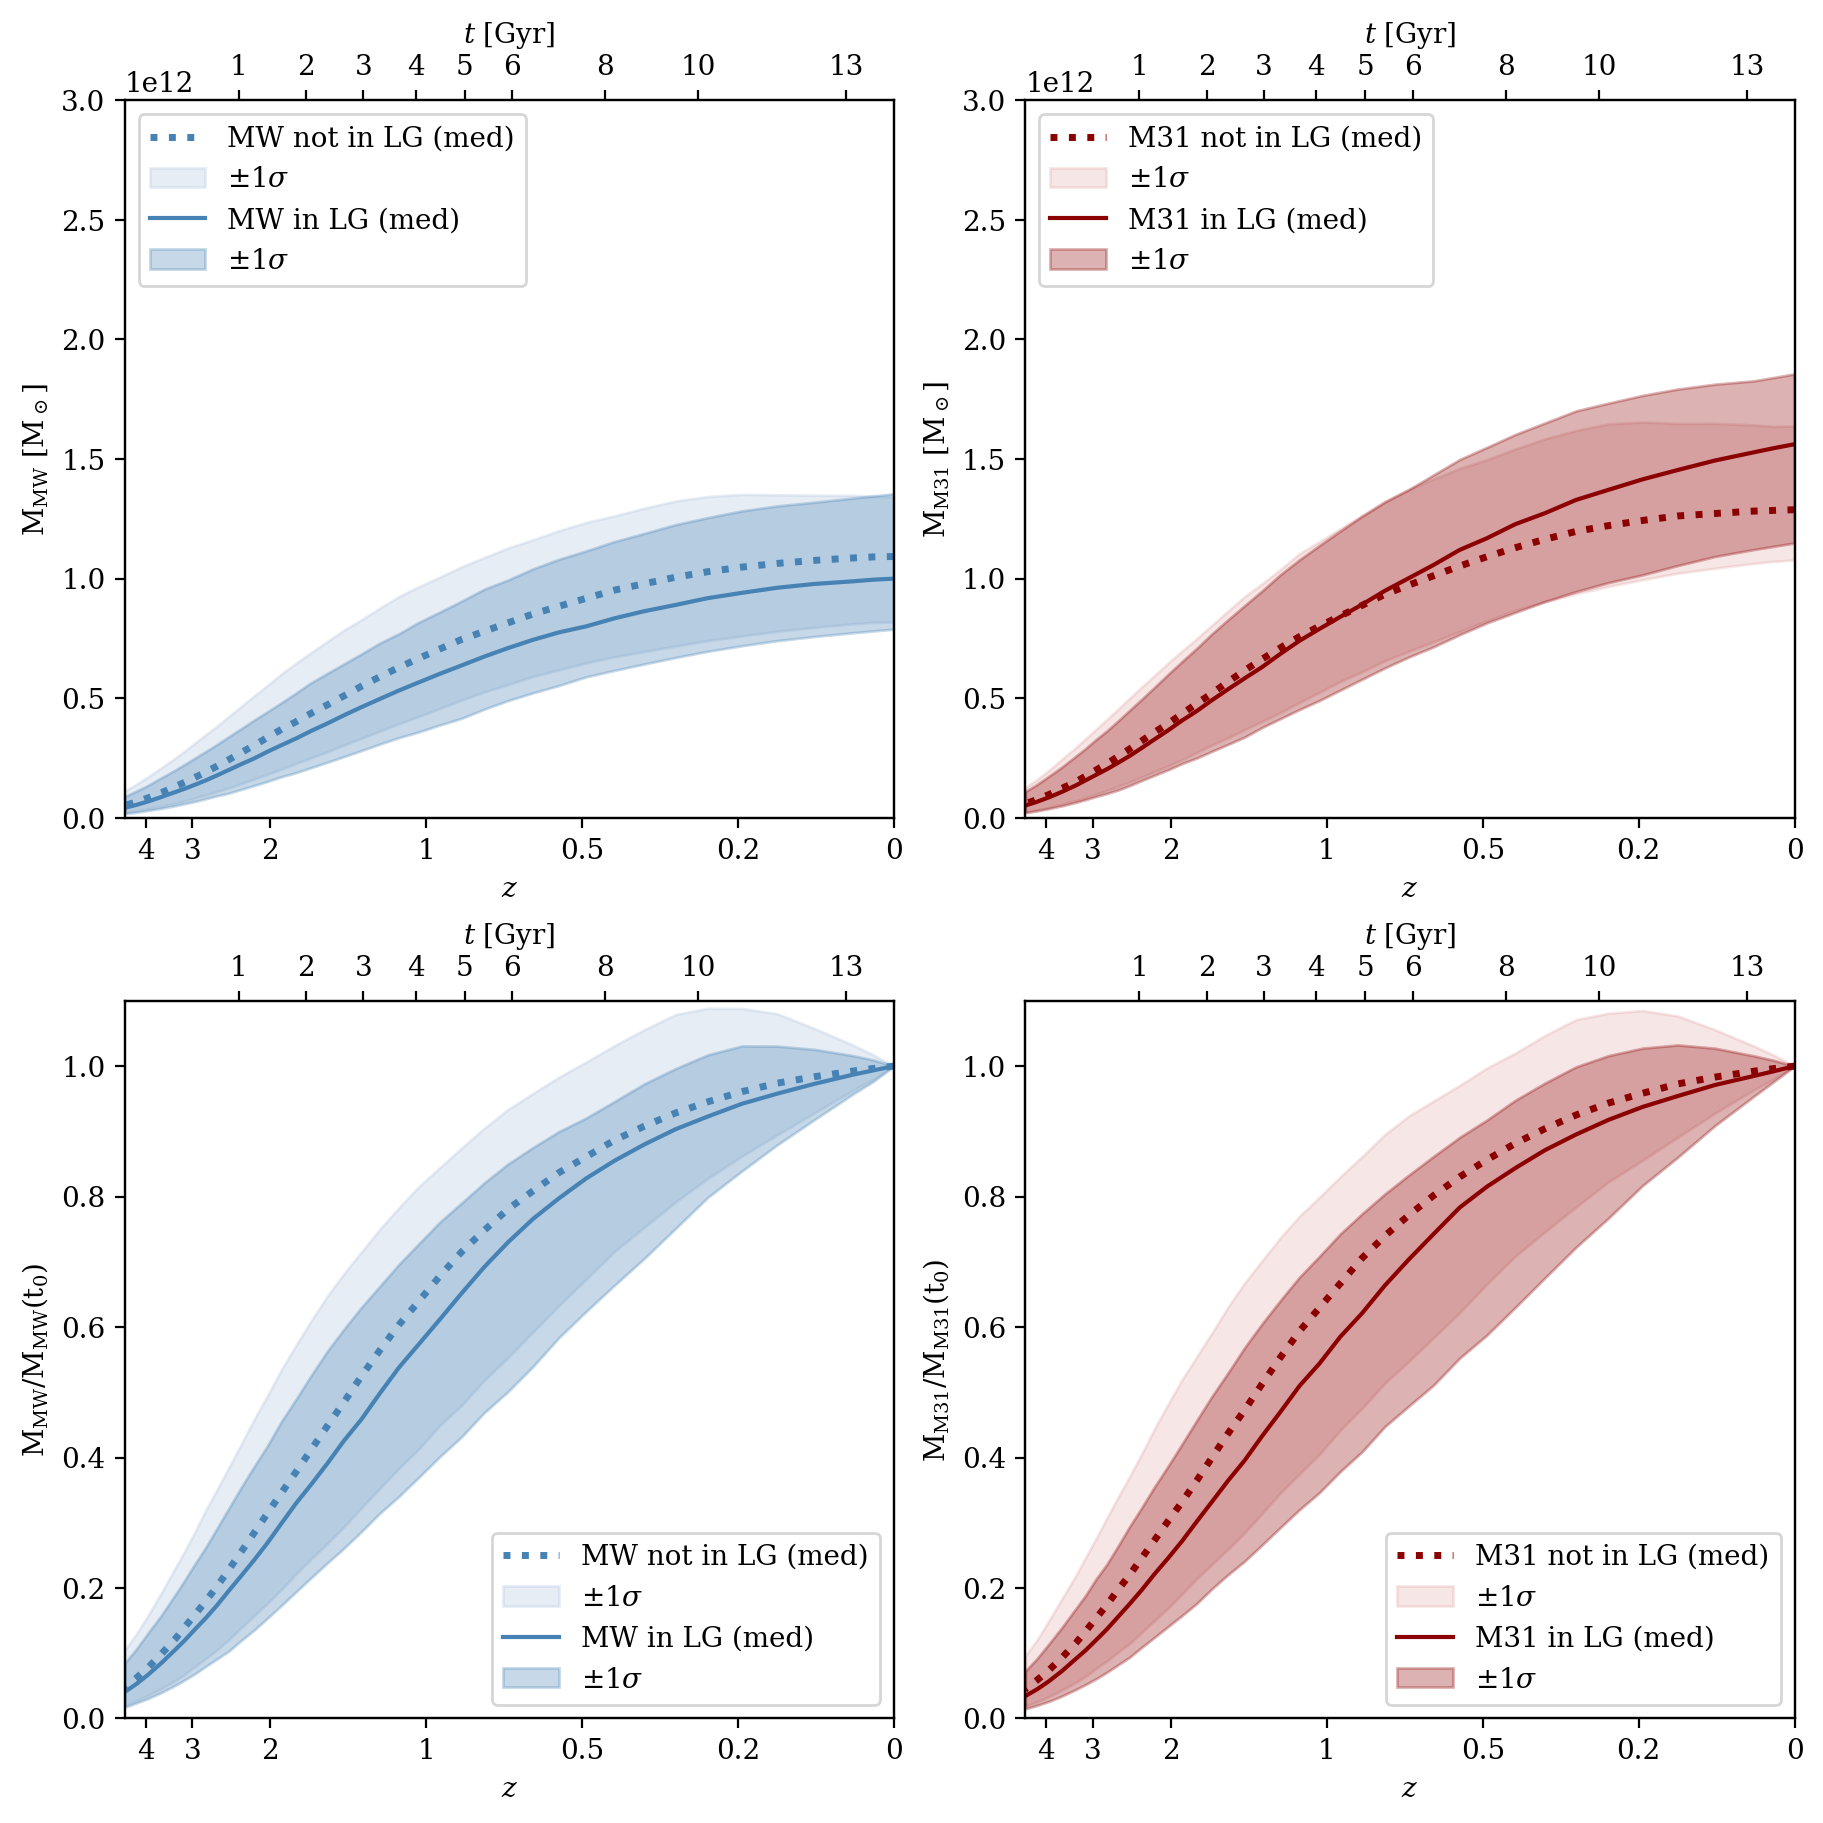

In [8]:
fig, axes = plt.subplots(figsize=(9,9), ncols=2, nrows=2, dpi=200, constrained_layout=True)
plot_style = {'color': 'r', 'linewidth': 0.5, 'linestyle': 'solid'}

ax_MW = axes[0][0]
ax_MW.plot(scale[fine_index], mass_data["no_LG"]["MW"]["med"], color='steelblue', linestyle=':', lw=2.5, label='MW not in LG (med)')
ax_MW.fill_between(scale[fine_index], mass_data["no_LG"]["MW"]["minus1"], mass_data["no_LG"]["MW"]["plus1"], color='lightsteelblue', alpha=0.3, label=r"$\pm 1\sigma$")
ax_MW.plot(scale[fine_index], mass_data["LG"]["MW"]["med"], color='steelblue', lw=1.5, label='MW in LG (med)')
ax_MW.fill_between(scale[fine_index], mass_data["LG"]["MW"]["minus1"], mass_data["LG"]["MW"]["plus1"], color='steelblue', alpha=0.3, label=r"$\pm 1\sigma$")
ax_MW.legend(loc='upper left')

ax_M31 = axes[0][1]
ax_M31.plot(scale[fine_index], mass_data["no_LG"]["M31"]["med"], color='darkred', linestyle=':', lw=2.5, label='M31 not in LG (med)')
ax_M31.fill_between(scale[fine_index], mass_data["no_LG"]["M31"]["minus1"], mass_data["no_LG"]["M31"]["plus1"], color='indianred', alpha=0.15, label=r"$\pm 1\sigma$")
ax_M31.plot(scale[fine_index], mass_data["LG"]["M31"]["med"], color='darkred', lw=1.5, label='M31 in LG (med)')
ax_M31.fill_between(scale[fine_index], mass_data["LG"]["M31"]["minus1"], mass_data["LG"]["M31"]["plus1"], color='darkred', alpha=0.3, label=r"$\pm 1\sigma$")
ax_M31.legend(loc='upper left')

ax_MW_norm = axes[1][0]
ax_MW_norm.plot(scale[fine_index], mass_data["no_LG"]["MW"]["med_norm"], color='steelblue', linestyle=':', lw=2.5, label='MW not in LG (med)')
ax_MW_norm.fill_between(scale[fine_index], mass_data["no_LG"]["MW"]["minus1_norm"], mass_data["no_LG"]["MW"]["plus1_norm"], color='lightsteelblue', alpha=0.3, label=r"$\pm 1\sigma$")
ax_MW_norm.plot(scale[fine_index], mass_data["LG"]["MW"]["med_norm"], color='steelblue', lw=1.5, label='MW in LG (med)')
ax_MW_norm.fill_between(scale[fine_index], mass_data["LG"]["MW"]["minus1_norm"], mass_data["LG"]["MW"]["plus1_norm"], color='steelblue', alpha=0.3, label=r"$\pm 1\sigma$")
ax_MW_norm.legend(loc='lower right')

ax_M31_norm = axes[1][1]
ax_M31_norm.plot(scale[fine_index], mass_data["no_LG"]["M31"]["med_norm"], color='darkred', linestyle=':', lw=2.5, label='M31 not in LG (med)')
ax_M31_norm.fill_between(scale[fine_index], mass_data["no_LG"]["M31"]["minus1_norm"], mass_data["no_LG"]["M31"]["plus1_norm"], color='indianred', alpha=0.15, label=r"$\pm 1\sigma$")
ax_M31_norm.plot(scale[fine_index], mass_data["LG"]["M31"]["med_norm"], color='darkred', lw=1.5, label='M31 in LG (med)')
ax_M31_norm.fill_between(scale[fine_index], mass_data["LG"]["M31"]["minus1_norm"], mass_data["LG"]["M31"]["plus1_norm"], color='darkred', alpha=0.3, label=r"$\pm 1\sigma$")
ax_M31_norm.legend(loc='lower right')


for ax in axes.flatten():

    # Setting the x axis (redshift)
    ax.set_xticks(label_scales)
    ax.set_xticklabels(label_redshifts_str)
    ax.set_xlabel(r'$z$')
    ax.set_xlim(min(scale[fine_index]), 1)

    # Setting the secondary x axis (time)
    ax2 = ax.twiny()
    ax2.set_xlabel(r'$t\ \mathrm{[Gyr]}$')
    ax2.set_xticks(ageticks)
    ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value])

axes[0][0].set_ylim(0, 3e12)
axes[0][0].set_ylabel(r'$\mathrm{M_{MW} \ [M_\odot]}$')

axes[0][1].set_ylim(0, 3e12)
axes[0][1].set_ylabel(r'$\mathrm{M_{M31} \ [M_\odot]}$')

axes[1][0].set_ylim(0, 1.1)
axes[1][0].set_ylabel(r'$\mathrm{M_{MW}/M_{MW}(t_0)}$')

axes[1][1].set_ylim(0, 1.1)
axes[1][1].set_ylabel(r'$\mathrm{M_{M31}/M_{M31}(t_0)}$')

plt.savefig('MW_M31_mass_evolution_comparaison.png')
plt.show()

## Ploting individual mass growth

In [9]:
#a refaire

def plot_individual_mass_growth(index=int, LG=bool, type_halo=list[str], normalise=False, mass_data=mass_data):
    """
    Plot the mass growth of one halo (MW or M31 in or out of LG conditions)
    
    Parameters :
        index : (int) No. of the halo in the list of halos we want to plot
        mass_data : (dict) dictionnary of all masses of MW and M31 in and out of a LG through the time
        LG : (bool) True/False
        type : (list of strings) ["MW"], ["M31"] or ["MW", "M31"]
        normalise : (bool) True/False
        """

    colors = {"MW": "steelblue", "M31":"darkred"}

    # Plotting
    fig, ax = plt.subplots(figsize=(7, 5), dpi=150)

    i = "LG" if LG else "no_LG"
    k = "norm" if normalise else "m"
    for j in type_halo:
        data_list = mass_data[i][j][k]

        if index < 0 or index >= len(data_list):
            print("Index out of number of halos !")
            return
        
        ax.plot(scale, data_list[index], lw=1.5, color=colors[j], marker='x', label= f"{type_halo} {'in LG' if LG else 'not in LG'}")
    
    # Axes
    ax.set_xticks(label_scales)
    ax.set_xticklabels(label_redshifts_str)
    ax.set_xlabel(r"$z$")
    ax.set_xlim(min(scale[fine_index]), 1)

    ax2 = ax.twiny()
    ax2.set_xlabel(r"$t\ \mathrm{[Gyr]}$")
    ax2.set_xticks(ageticks)
    ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value])

    ax.set_ylabel(r"$\mathrm{M/M(t_0)}$" if normalise else r"$\mathrm{Mass\ [M_\odot]}$")
    ax.grid(True)

    title = f"{' and '.join(type_halo)} – No. {index} – {'Normalised' if normalise else 'Absolute'} mass growth"
    ax.set_title(title)

    plt.tight_layout()
    plt.show()

    return

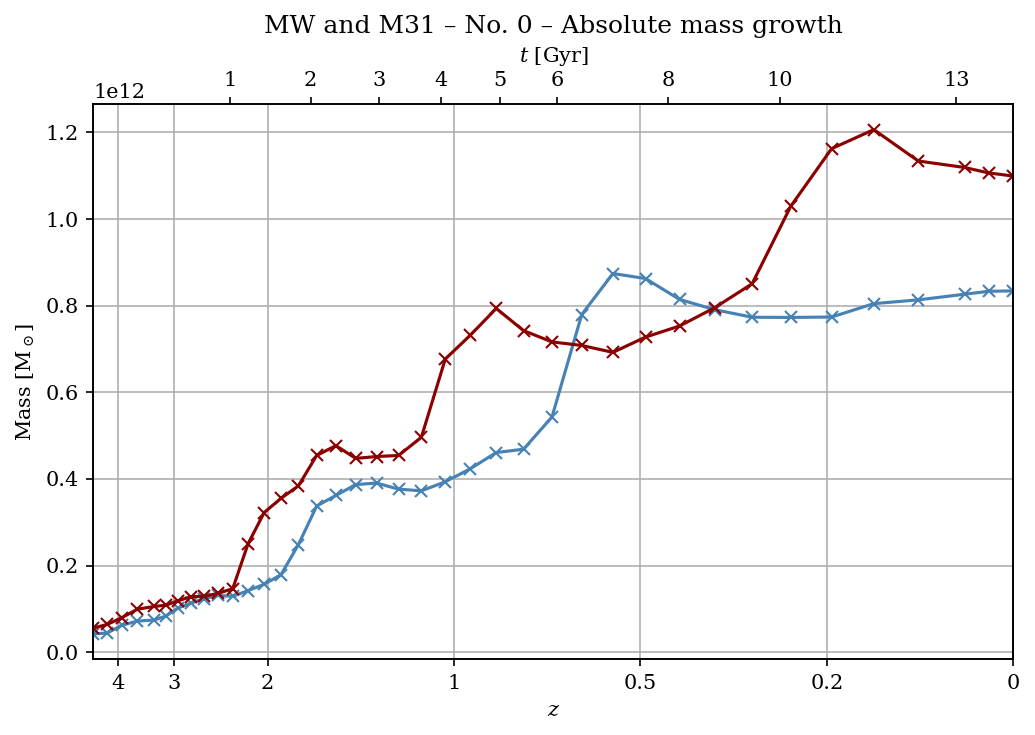

In [10]:
plot_individual_mass_growth(0, False, ["MW", "M31"])

## Computing and ploting the probability density of $z_x$ in different situations (where $z_x$ is the redshift when the galaxy gets $x$% of its current mass)

### Defining function for computation

In [11]:
def idx_zx(x): # we look for the idx where the mass is the closest to x% of the final mass

    idx_zx_MW_LG = np.argmin(np.abs(mass_data["LG"]["MW"]["norm"] - x/100), axis=1)
    idx_zx_MW_no_LG = np.argmin(np.abs(mass_data["no_LG"]["MW"]["norm"] - x/100), axis=1)
    idx_zx_M31_LG = np.argmin(np.abs(mass_data["LG"]["M31"]["norm"] - x/100), axis=1)
    idx_zx_M31_no_LG = np.argmin(np.abs(mass_data["no_LG"]["M31"]["norm"] - x/100), axis=1)

    return idx_zx_MW_LG, idx_zx_MW_no_LG, idx_zx_M31_LG, idx_zx_M31_no_LG


def a_zx(idx_MW_LG, idx_MW_no_LG, idx_M31_LG, idx_M31_no_LG): # we will plot as a function of the scale factor

    a_zx_MW_LG = scale[fine_index][idx_MW_LG]
    a_zx_MW_no_LG = scale[fine_index][idx_MW_no_LG]
    a_zx_M31_LG = scale[fine_index][idx_M31_LG]
    a_zx_M31_no_LG = scale[fine_index][idx_M31_no_LG]

    a_zx = [a_zx_MW_LG, a_zx_MW_no_LG, a_zx_M31_LG, a_zx_M31_no_LG]

    return a_zx


def plot_zx_density_proba(percentages, series_to_plot, legend_dict=None, legend_loc=None, global_title=None, save_file=None):
    """
    Makes a 2x2 grid of probability densities for 4 different values of zx

    Parameters :
      percentages : list of 4 percentages
      series_to_plot : list of keys specifying which series to plot. Choose 1-4 between "zx_MW_LG", "zx_MW_no_LG", "zx_M31_LG", "zx_M31_no_LG".
      legend_dict : optionnal dictionary which associates a list of legend handles to be used for each percentage.
      legend_loc : optionnal dictionary setting the position of the legend (Upper right if None)
      global_title : optionnal - title of the plot.
      save_file : optionnal - file adress to save
    """

    # Setting dictionaries used later
    color_dict = {"zx_MW_LG": "steelblue", "zx_MW_no_LG": "lightsteelblue", "zx_M31_LG": "darkred", "zx_M31_no_LG": "lightcoral"}
    series_index = {"zx_MW_LG": 0, "zx_MW_no_LG": 1, "zx_M31_LG": 2, "zx_M31_no_LG": 3}
    
    # We adapt the size of the grid depending on the number of subplots we want by approximating a square
    n = len(percentages)
    nrows = int(np.floor(np.sqrt(n)))
    ncols = int(np.ceil(n/nrows))

    # We assume that len(percentages)==4 and we create a 2x2 grid.
    fig, axes = plt.subplots(figsize=(4.5*ncols, 4.5*nrows), ncols=ncols, nrows=nrows, dpi=200, constrained_layout=True)
    
    # axes is transformed to be a 1D array
    if n == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()   

    # Loop over the percentages and plot on the corresponding subplot
    for i, perc in enumerate(percentages):
        # Compute the values for this percentage
        data = a_zx(*idx_zx(perc))
        # data = [zx_MW_LG, zx_MW_no_LG, zx_M31_LG, zx_M31_no_LG] 

        ax = axes[i]
        # For each asked series, we plot the kdeplot
        for j in series_to_plot:
            data_series = data[ series_index[j] ]
            sns.kdeplot(data_series, fill=True, label=j, color=color_dict.get(j, None), ax=ax, bw_adjust=1.4)
        
        # If legend_dict is given for this percentage, we use it
        if legend_dict is not None and perc in legend_dict:
            handles=[legend_dict[perc][k] for k in series_to_plot]
            if legend_loc is not None and perc in legend_loc:
                ax.legend(handles=handles, loc=legend_loc[perc])
            else: ax.legend(handles=handles, loc="upper right")
        
        # Setting the x axis (redshift)
        ax.set_xticks(label_scales)
        ax.set_xticklabels(label_redshifts_str)
        ax.set_xlabel(r"$z$")
        ax.set_ylabel("Probability density")
        
        # Setting the secondary x axis (time)
        ax2 = ax.twiny()
        ax2.set_xlabel(r"$t\ \mathrm{[Gyr]}$")
        ax2.set_xticks(ageticks)
        ax2.set_xticklabels(['{:g}'.format(age) for age in ages.value])
        ax2.set_xlim(ax.get_xlim())
    
    if global_title:
        fig.suptitle(global_title, fontsize=16)
    
    plt.xlim(min(scale[fine_index]), 1)

    if save_file is not None:
        plt.savefig(save_file)
    plt.show()
    
    return

### Plots

#### Setting parameters for the plotting

In [12]:
percentages = [10,30,50,90]

def legend_dict_compact(x):
    return {
                    "zx_MW_LG": mpatches.Patch(color='steelblue', alpha=0.5, label=f'$z_{{{x}}}$ MW in LG'),
                    "zx_MW_no_LG": mpatches.Patch(color='lightsteelblue', alpha=0.5, label=f'$z_{{{x}}}$ MW not in LG'),
                    "zx_M31_LG" :mpatches.Patch(color='darkred', alpha=0.5, label=f'$z_{{{x}}}$ M31 in LG'), 
                    "zx_M31_no_LG" :mpatches.Patch(color='lightcoral', alpha=0.5, label=f'$z_{{{x}}}$ M31 not in LG')
}

legend_dict = {p: legend_dict_compact(p) for p in percentages}

legend_loc = {p: ("upper right" if p<85 else "upper left") for p in percentages}

#### Probability density of $z_x$ for selected MW and M31 in LG

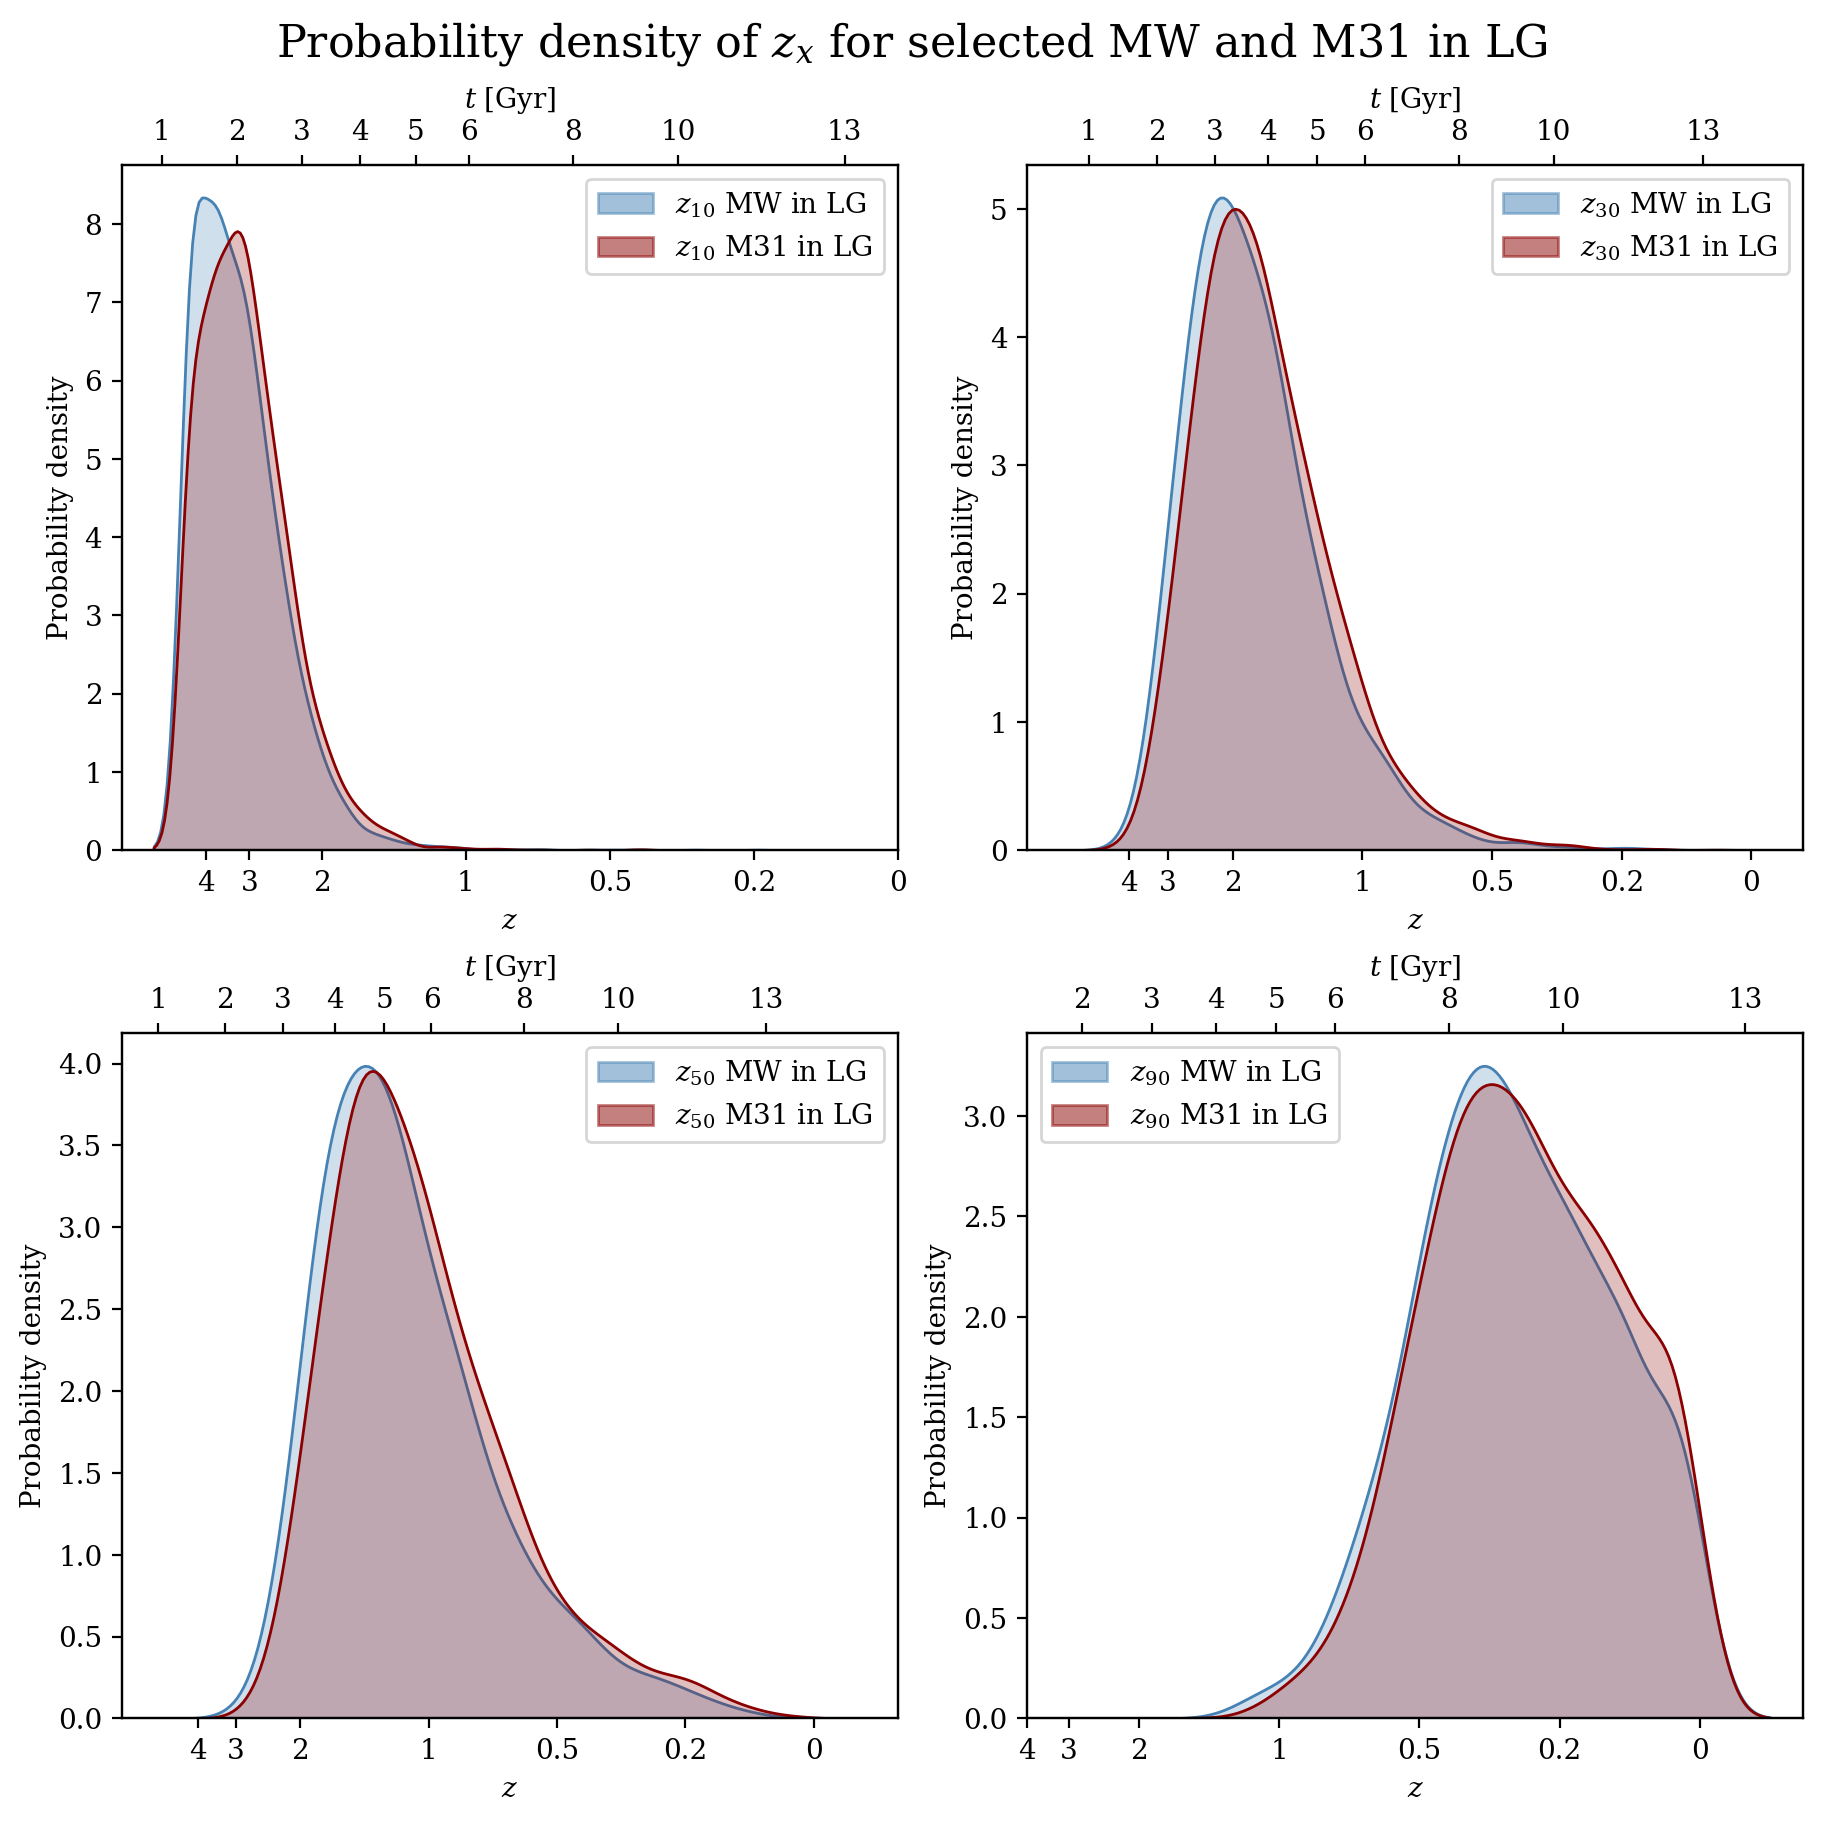

In [13]:
series_to_plot = ["zx_MW_LG", "zx_M31_LG"]

global_title = r"Probability density of $z_x$ for selected MW and M31 in LG"
save_file = global_title + ".png"

plot_zx_density_proba(percentages=percentages, series_to_plot=series_to_plot, legend_dict=legend_dict, legend_loc=legend_loc, global_title=global_title, save_file=save_file)

#### Probability density of $z_x$ for selected MW and M31 no LG

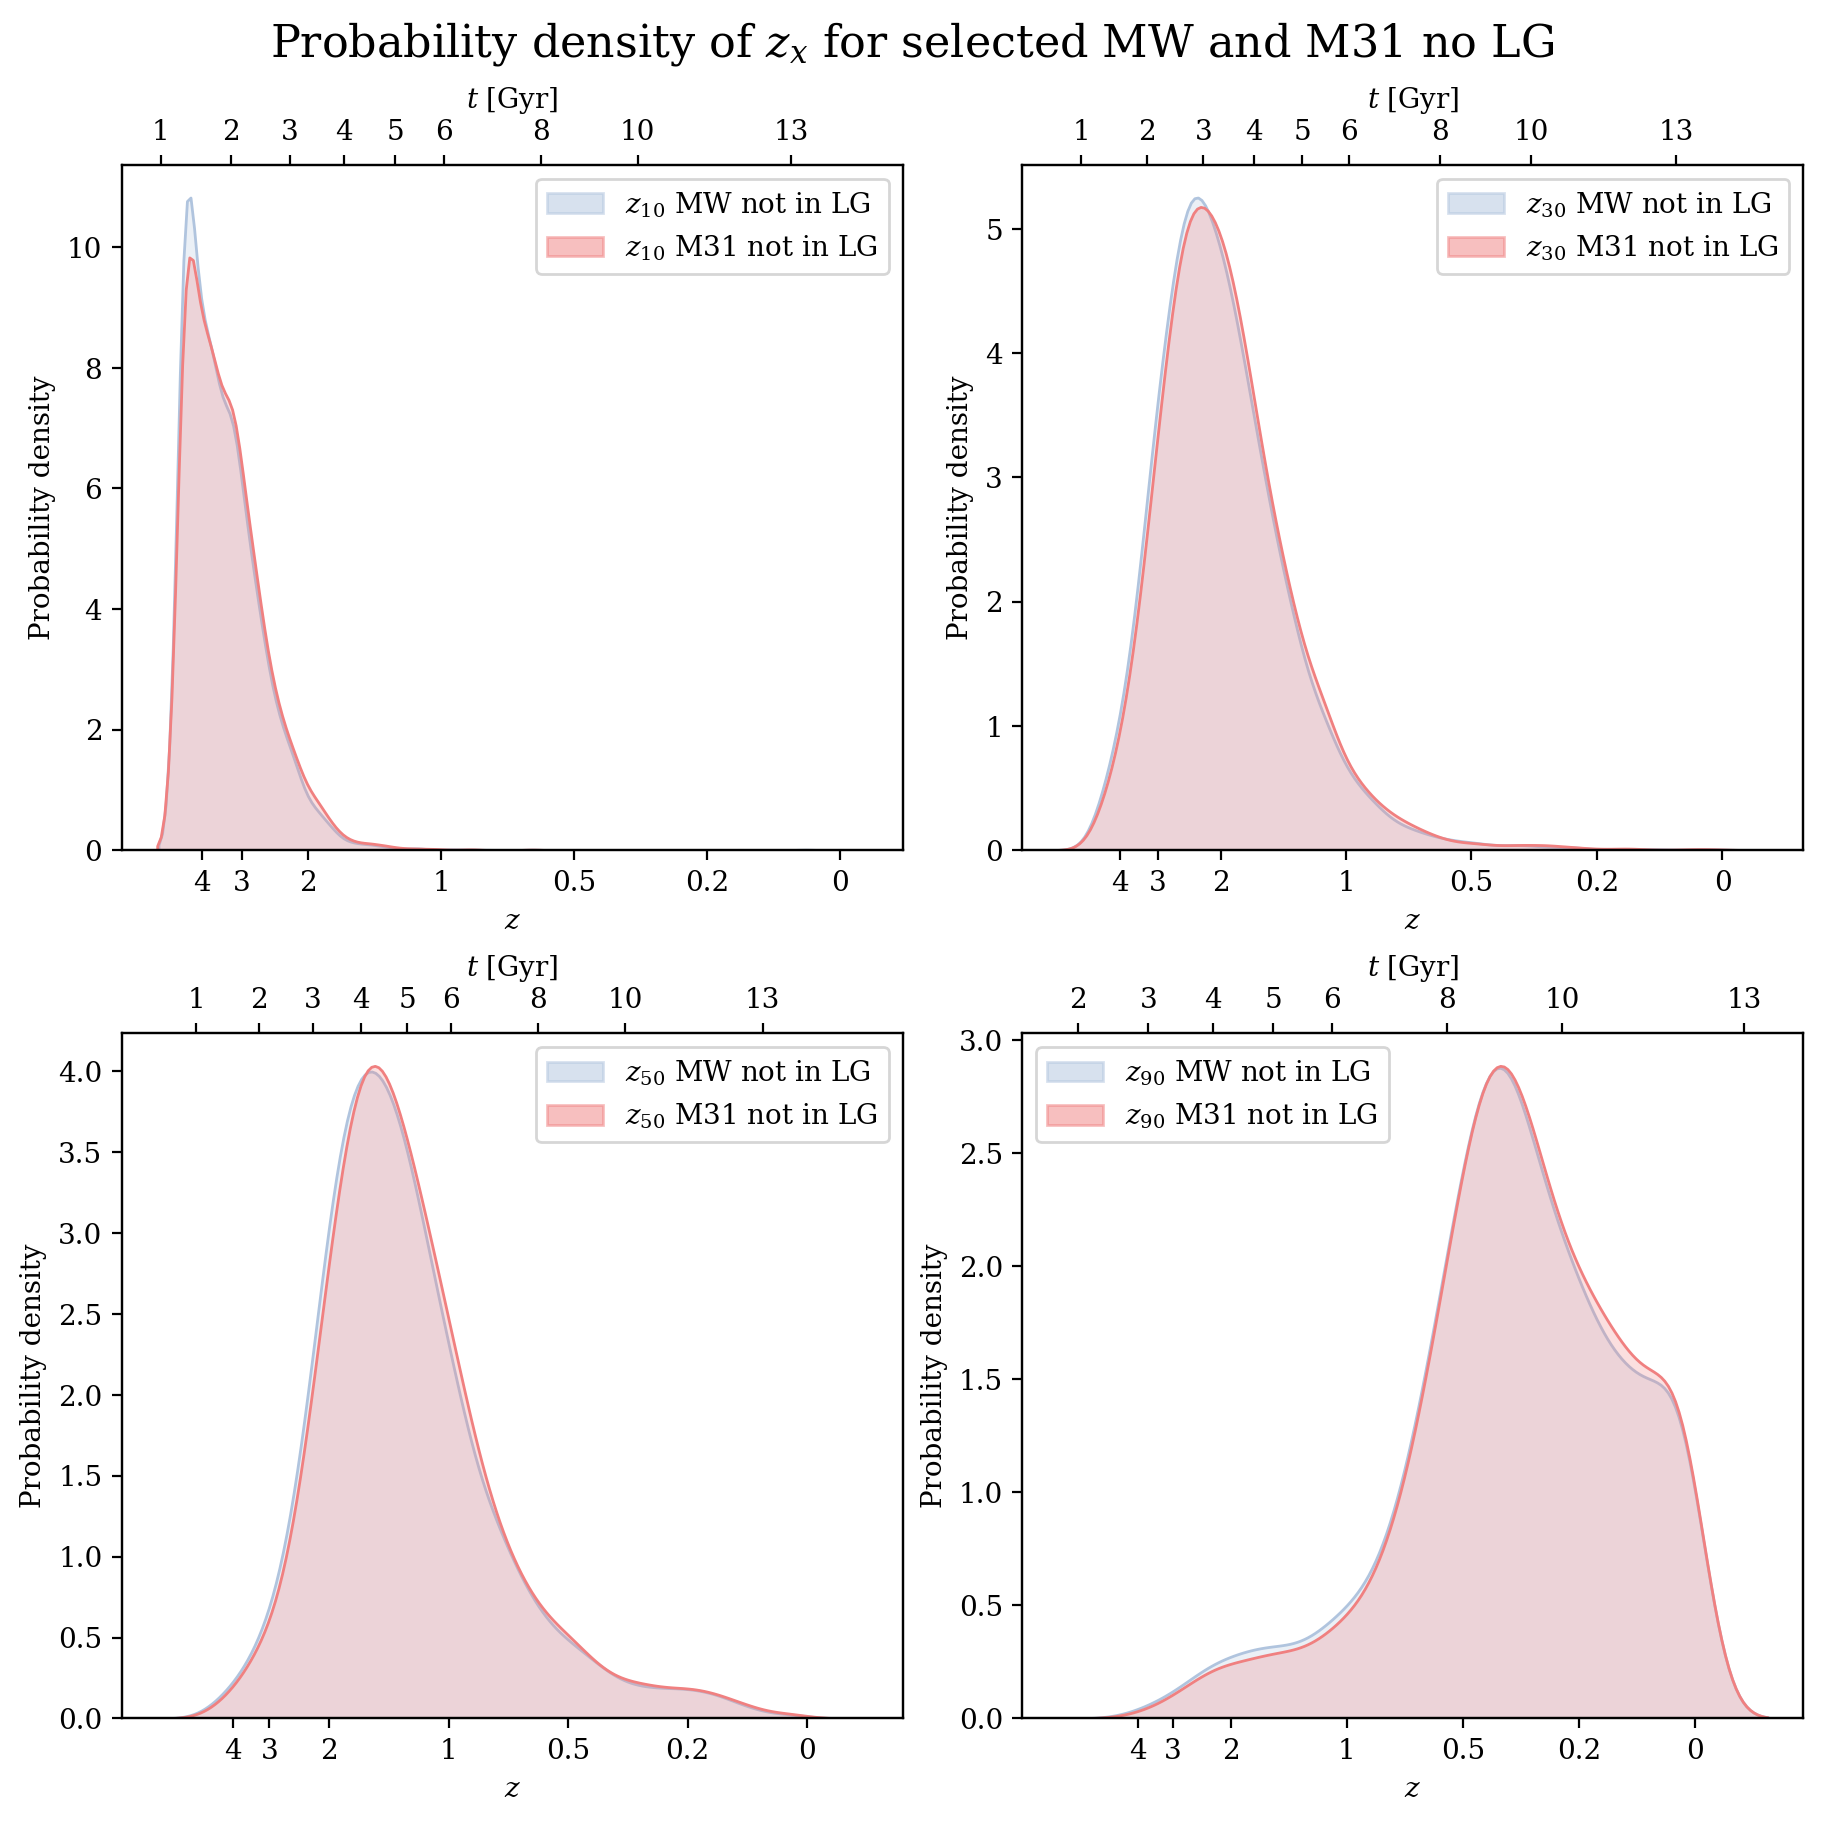

In [14]:
series_to_plot = ["zx_MW_no_LG", "zx_M31_no_LG"]

global_title = r"Probability density of $z_x$ for selected MW and M31 no LG"
save_file = global_title + ".png"

plot_zx_density_proba(percentages=percentages, series_to_plot=series_to_plot, legend_dict=legend_dict, legend_loc=legend_loc, global_title=global_title, save_file=save_file)

#### Probability density of $z_x$ for selected MW in and not in LG

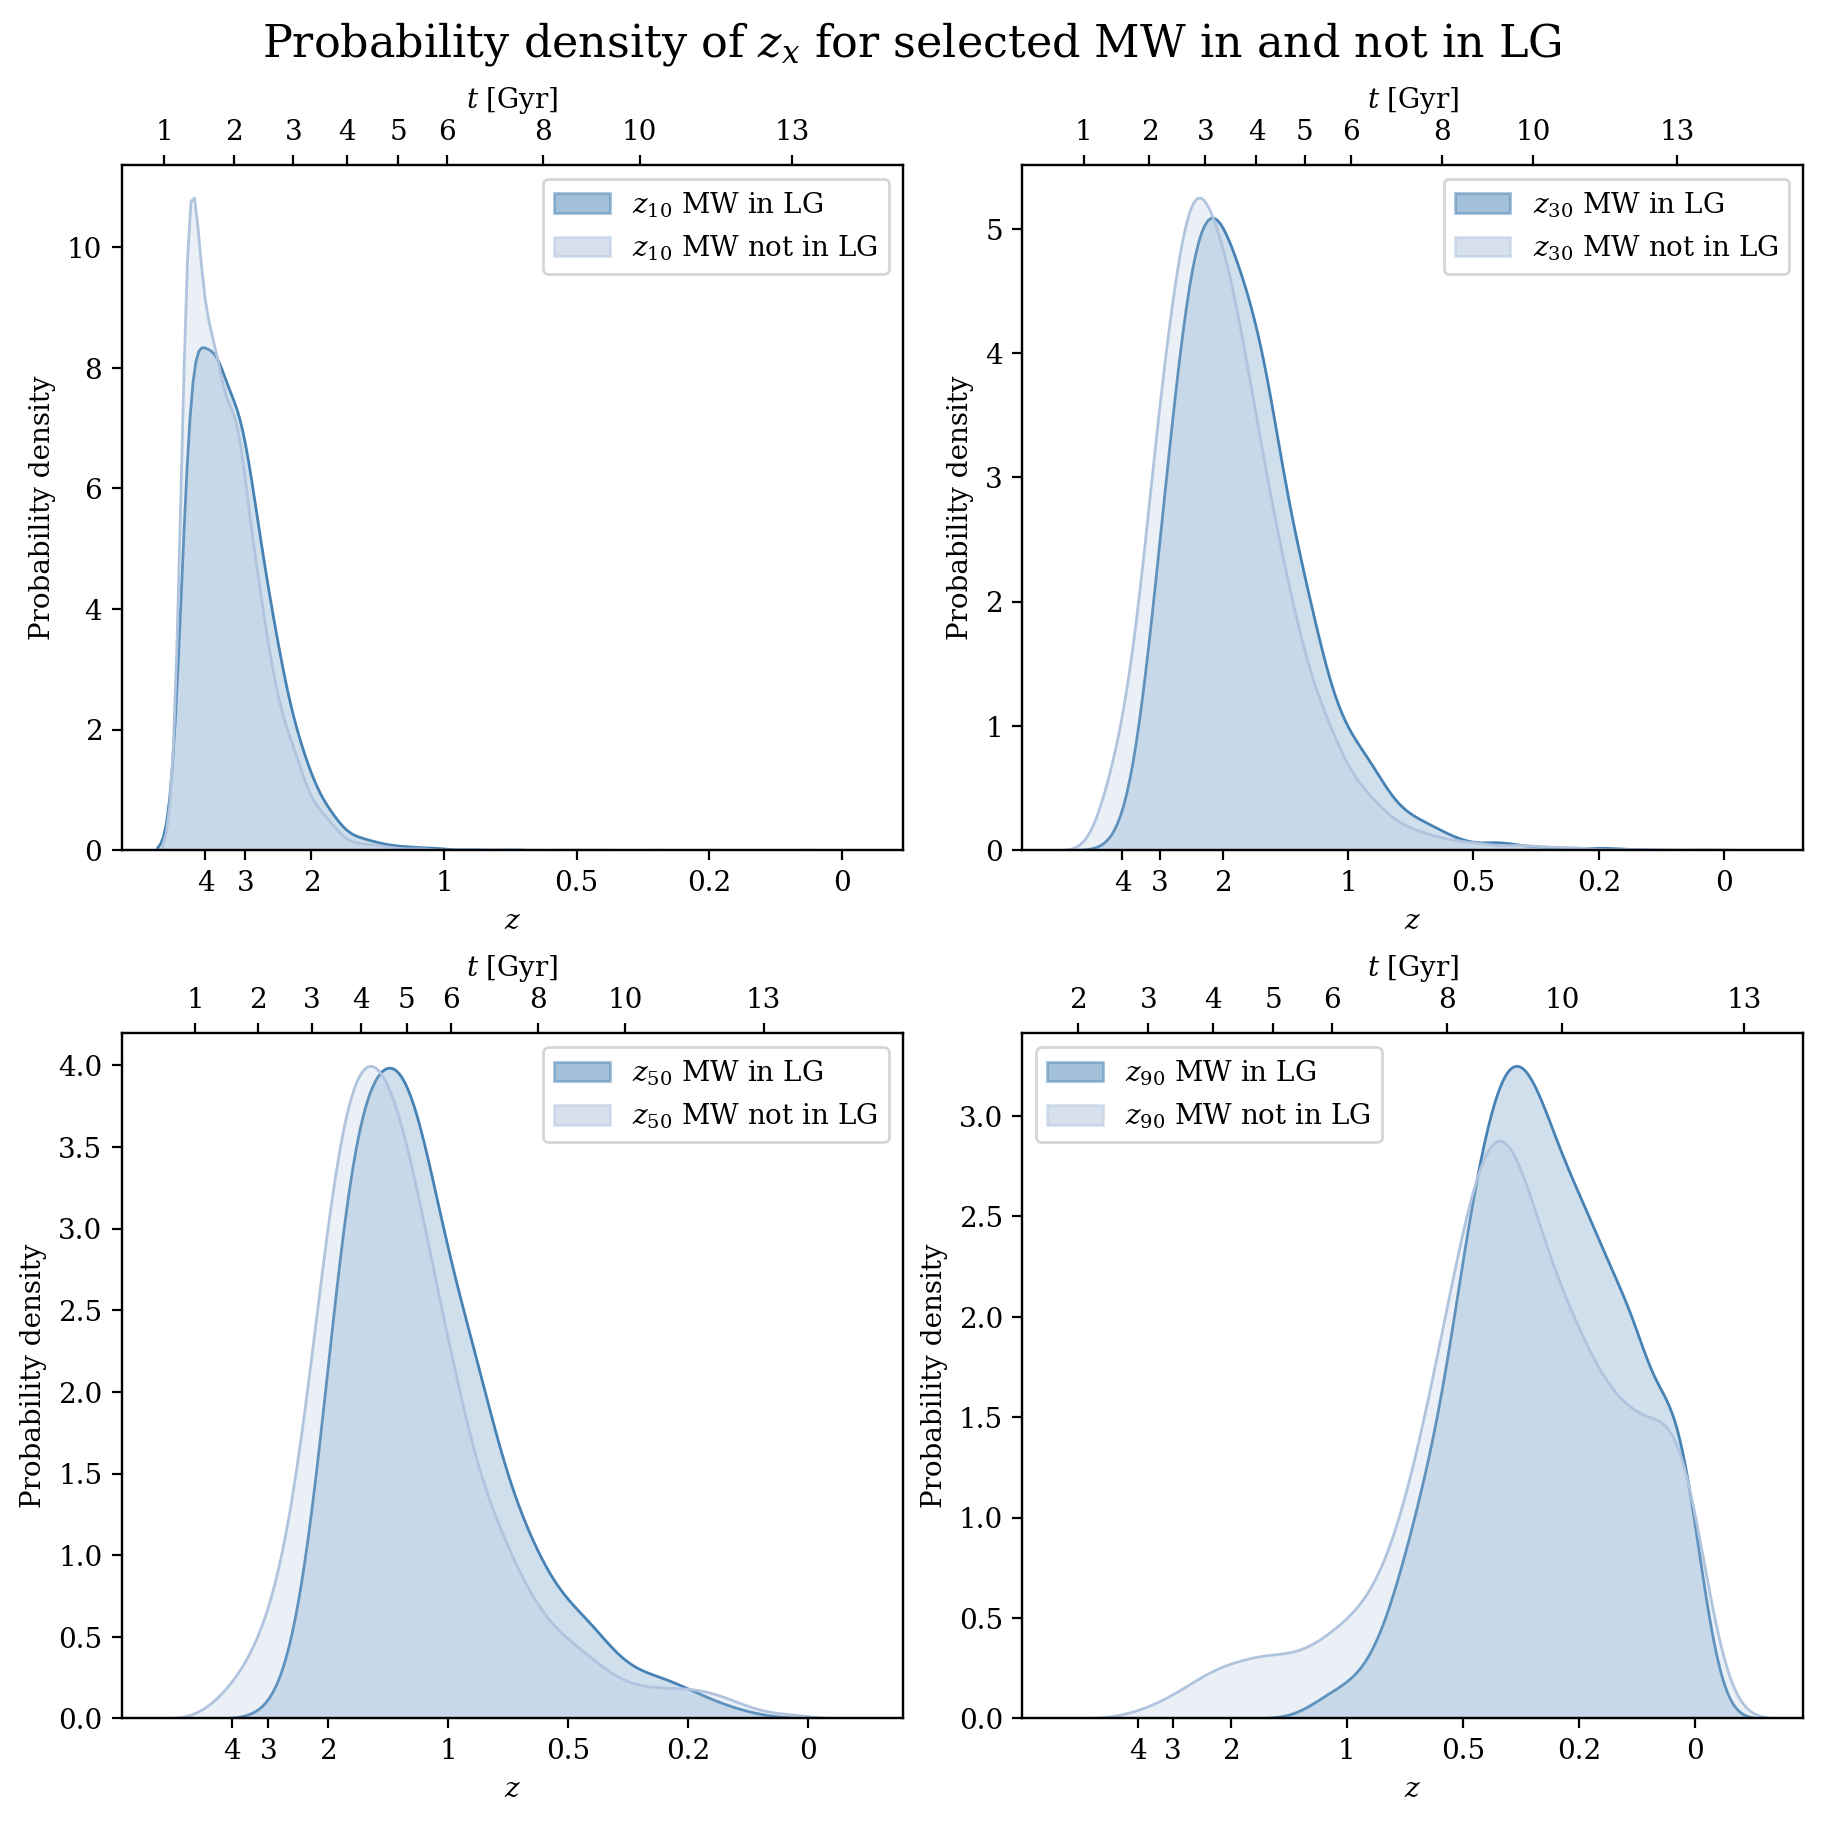

In [15]:
series_to_plot = ["zx_MW_LG", "zx_MW_no_LG"]

global_title = r"Probability density of $z_x$ for selected MW in and not in LG"
save_file = global_title + ".png"  

plot_zx_density_proba(percentages=percentages, series_to_plot=series_to_plot, legend_dict=legend_dict, legend_loc=legend_loc, global_title=global_title, save_file=save_file)


#### Probability density of $z_x$ for selected M31 in and not in LG

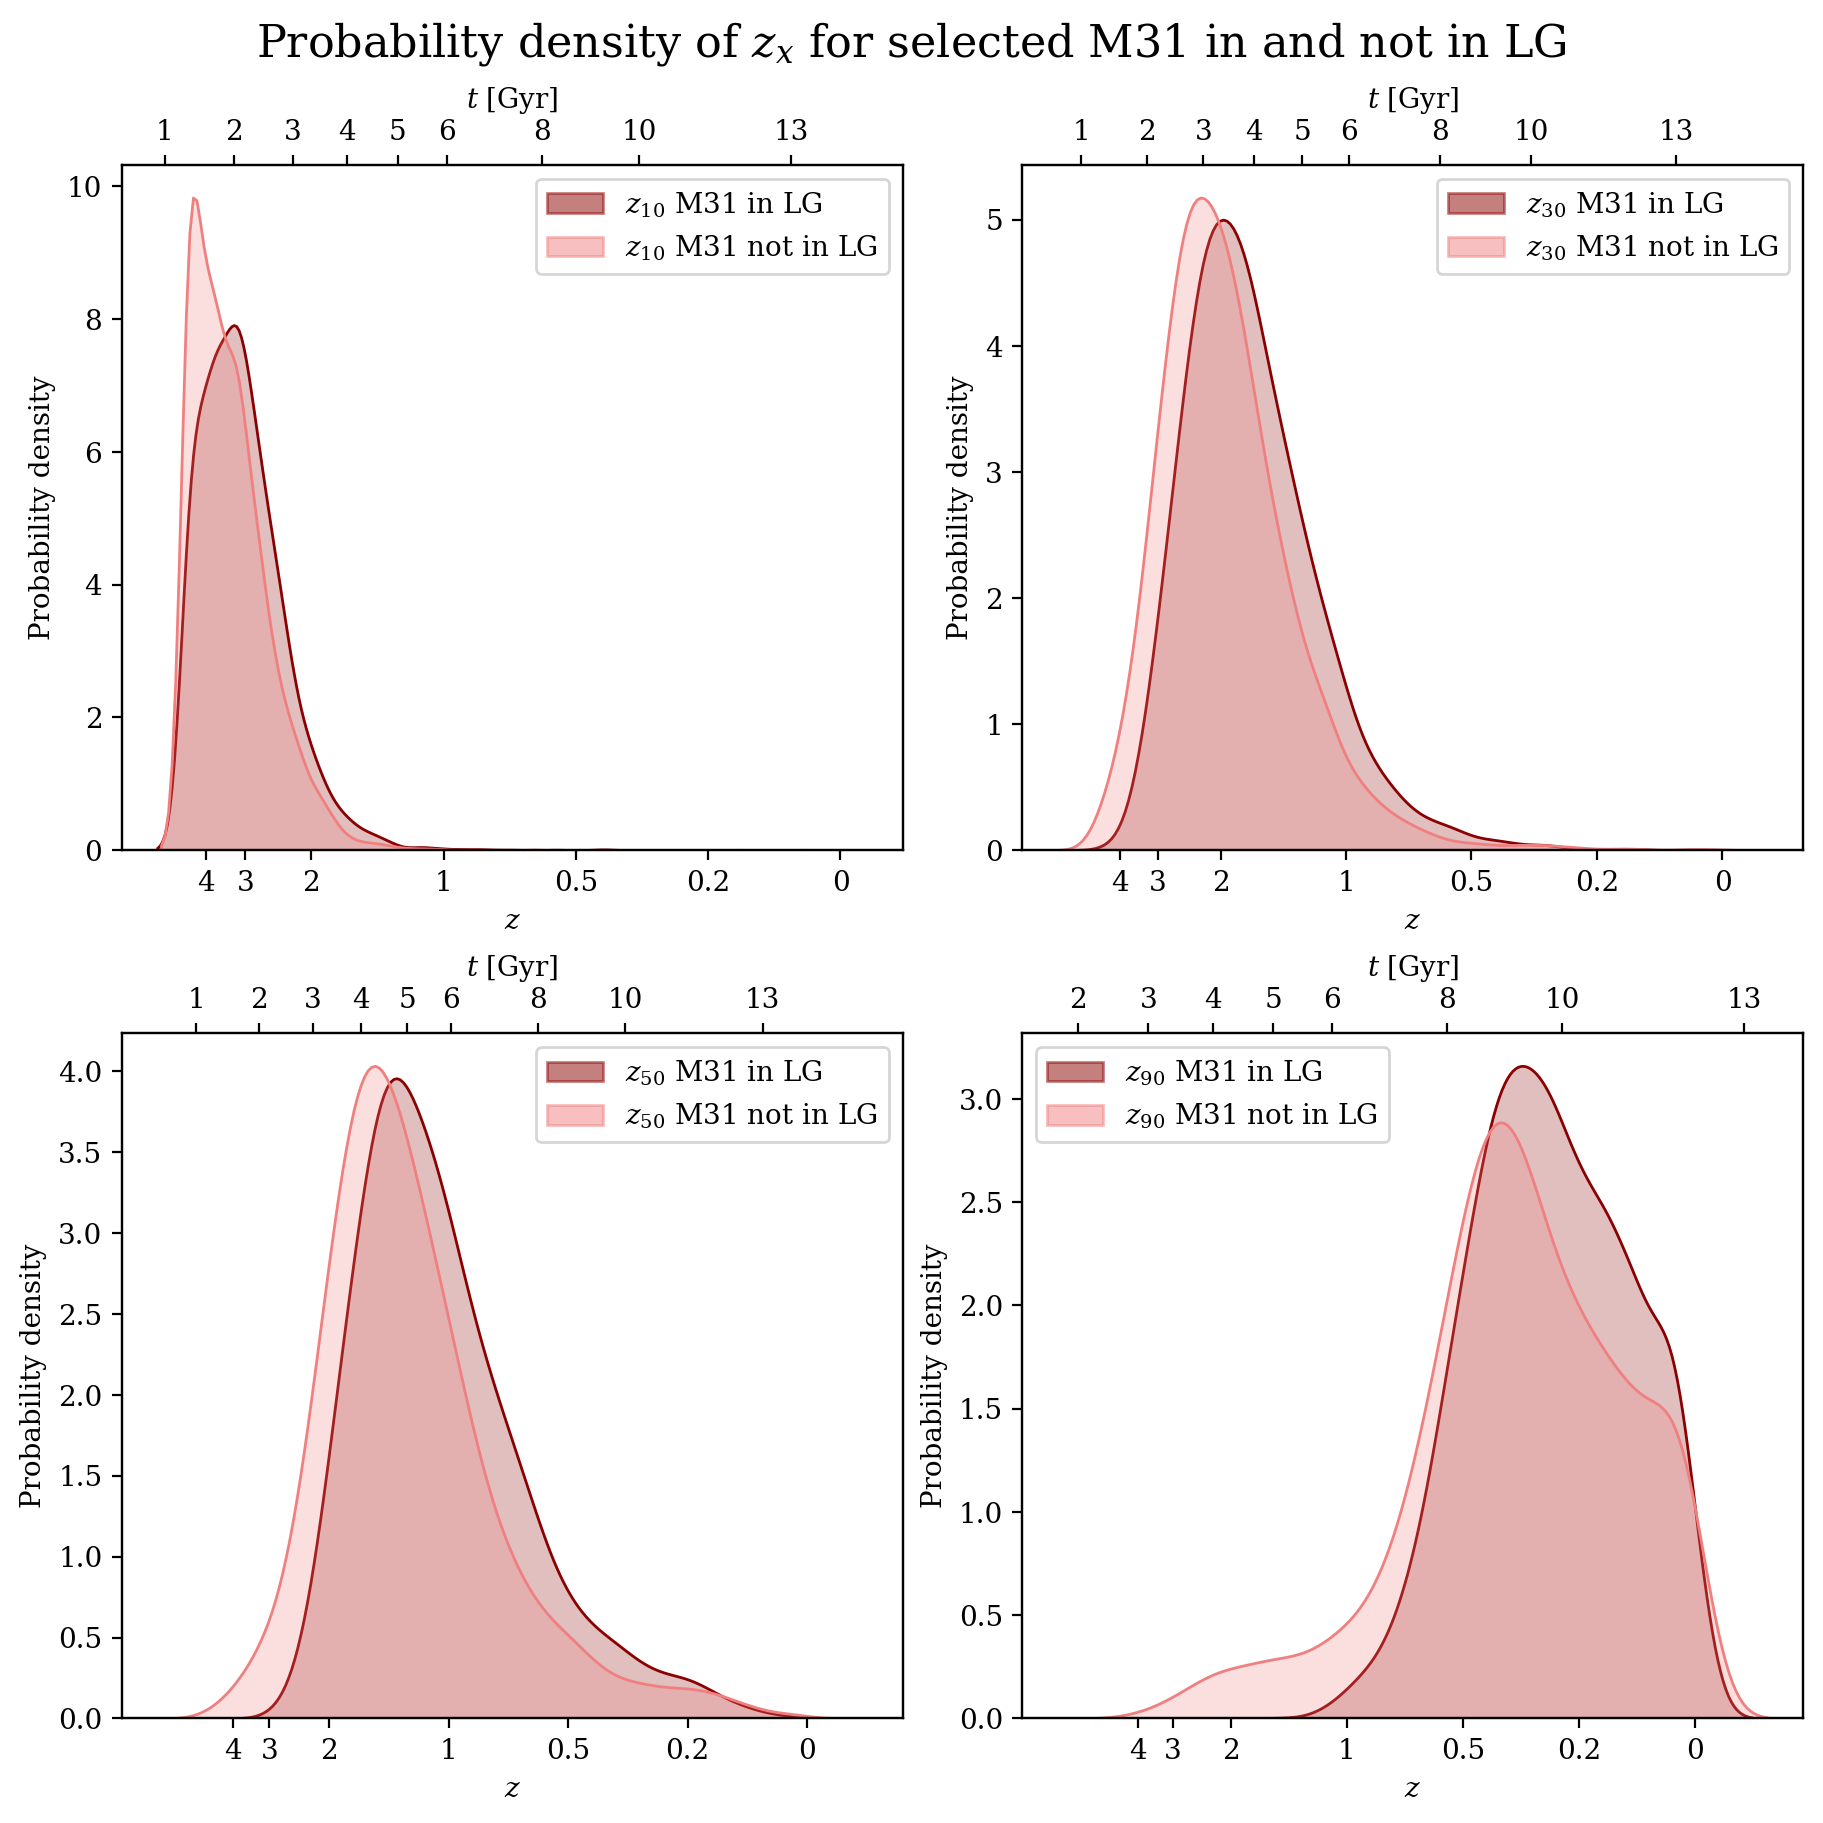

In [16]:
series_to_plot = ["zx_M31_LG", "zx_M31_no_LG"]

global_title = r"Probability density of $z_x$ for selected M31 in and not in LG"
save_file = global_title + ".png"  

plot_zx_density_proba(percentages=percentages, series_to_plot=series_to_plot, legend_dict=legend_dict, legend_loc=legend_loc, global_title=global_title, save_file=save_file)

#### Probability density of $z_x$ for selected MW and M31 in and not in LG

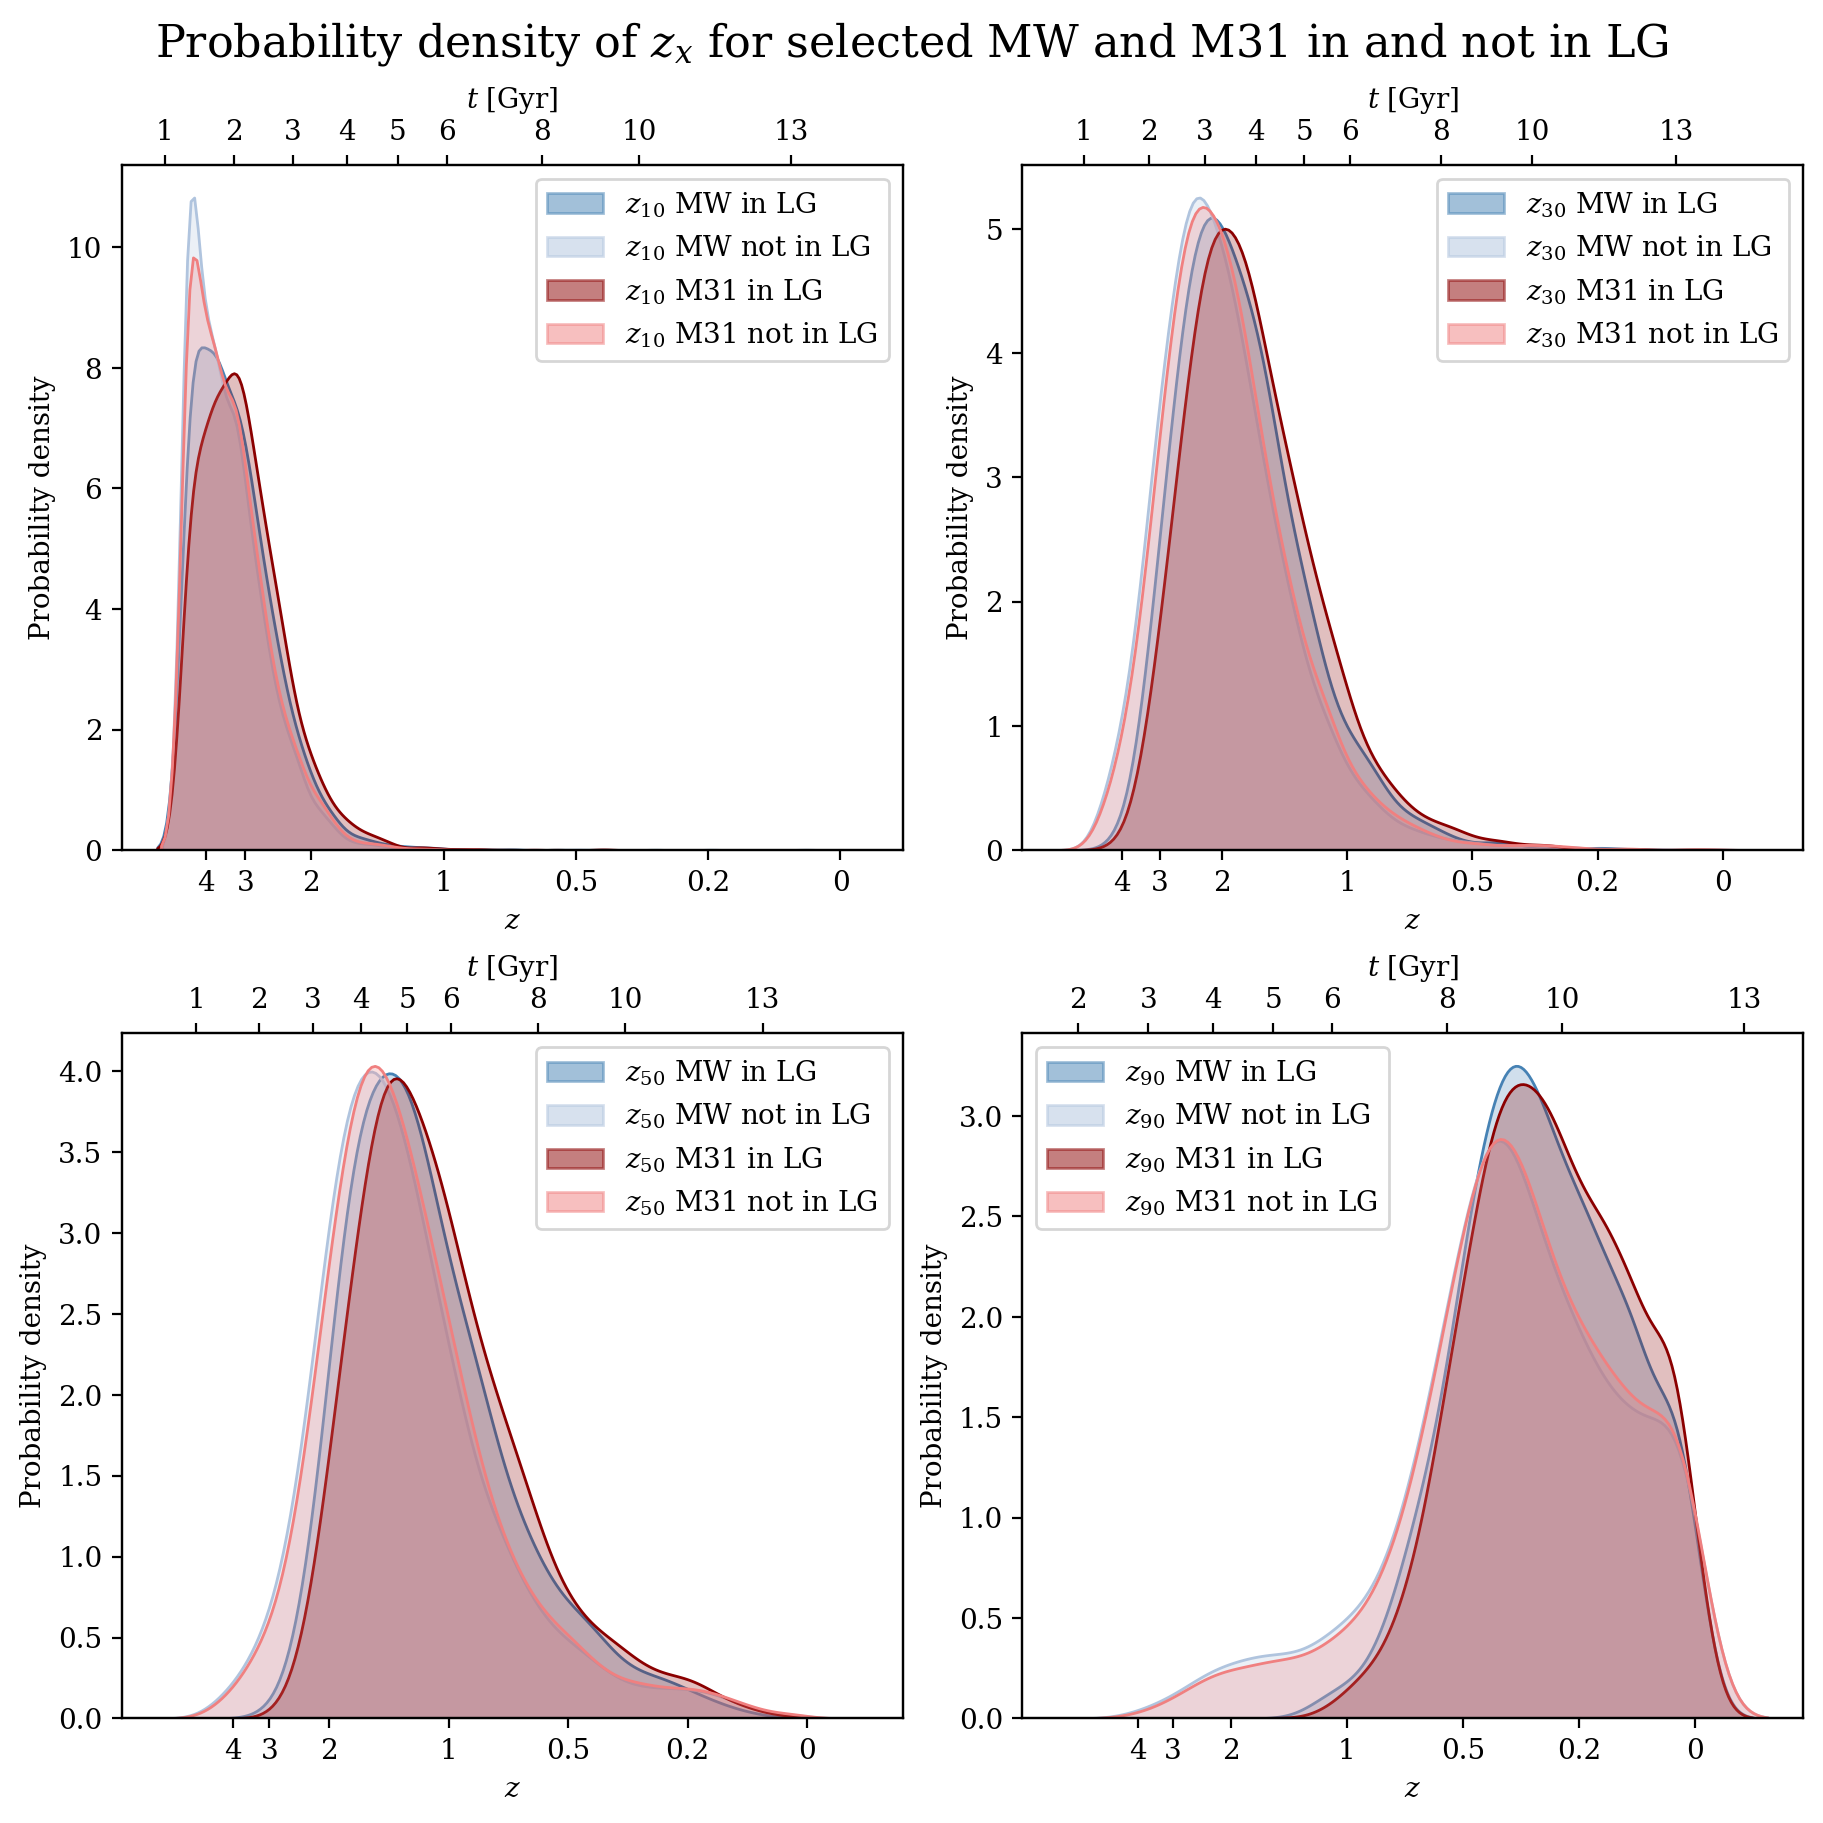

In [17]:
series_to_plot = ["zx_MW_LG","zx_MW_no_LG","zx_M31_LG","zx_M31_no_LG"]

global_title = r"Probability density of $z_x$ for selected MW and M31 in and not in LG"
save_file = global_title + ".png"  

plot_zx_density_proba(percentages=percentages, series_to_plot=series_to_plot, legend_dict=legend_dict, legend_loc=legend_loc, global_title=global_title, save_file=save_file)

## Looking for correlations

### Defining functions for computing and ploting a scatter, covariance matrix and correlation matrix

In [18]:
def scatter_and_covariance(data1, data2, data3=None, labels=None, title_scatter="Scatter plot", title_cov="Covariance matrix", save_file=None):
    """
    Makes a scatter plot (data1 vs data 2) and the covariance matrix
    Parameters :
    data1 : 1D list (X axis)
    data2 : 1D list (Y axis)
    data3 : 1D list (color scale), optional.
    title_scatter (str) : Title for scatter.
    title_cov (str) : Title for covariance matrix.
    save_file (str or None) : Path to save figure.
    """
    # Compute the covariance matrix
    cov_matrix = np.cov([data1, data2])
    # coefficient (Spearman)
    corr_coef, p_value = spearmanr(data1, data2)

    # Plot
    fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

    # If no label is given, we set default labels
    if labels is None:
        labels = ["Var 1", "Var 2"]

    # Scatter
    ax_scatter = axes[0]
    scatter = ax_scatter.scatter(data1, data2, c=data3 if data3 is not None else 'darkolivegreen', cmap='viridis', alpha=0.7, marker='x', s=20)
    ax_scatter.set_xlabel(labels[0])
    ax_scatter.set_ylabel(labels[1])
    ax_scatter.set_title(f"{title_scatter}\nCorr = {corr_coef:.2f}")

    # Add colorbar if needed
    if data3 is not None:
        cbar = fig.colorbar(scatter, ax=ax_scatter)
        cbar.set_label(labels[2] if len(labels)>2 else "Var 3")
    
    # Covariance matrix
    ax_cov = axes[1]
    bar = ax_cov.imshow(cov_matrix, cmap='viridis')
    ax_cov.set_title(title_cov)
    
    ax_cov.set_xticks([0, 1])
    ax_cov.set_xticklabels(labels[:2])
    ax_cov.set_yticks([0, 1])
    ax_cov.set_yticklabels(labels[:2])

    for i in range(2):
        for j in range(2):
            ax_cov.text(j, i, f"{cov_matrix[i, j]:.2e}", ha="center", va="center", color="w", fontsize=12)
    
    fig.colorbar(bar, ax=ax_cov)
    plt.tight_layout()
    if save_file is not None:
        plt.savefig(save_file)
    plt.show()
    
    return


def plot_correlation_matrix(data, labels=None, title="Correlation matrix", save_file=None):
    """
    Complute and plot the correlation matrix for N variables.
        
    Parameters :
        data : ND array where each line represent a data and each column a value.
        labels : 1D list of names for each variable (size : N)
        title : Plot title
    """
    # Compute the correlation matrix
    corr_matrix, _ = stats.spearmanr(data, axis=1)
        
    # Create the figure
    fig, ax = plt.subplots(figsize=(len(data)/1.5, len(data)/1.5))
    bar = ax.imshow(corr_matrix, cmap='RdBu', vmin=-1, vmax=1)
    ax.set_title(title, fontsize=2*len(data), fontweight="bold")
        
    # If no label is given, we set default labels
    if labels is None:
        n = corr_matrix.shape[0]
        labels = [f"Var {i+1}" for i in range(n)]
        
    # Ticks position and label
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", va="top", rotation_mode="anchor")
        
    # Show in each cell the correlation value
    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            ax.text(j, i, f"{corr_matrix[i, j]:.2f}",
            ha="center", va="center", color="black", fontsize=12)
    
    plt.tight_layout()
    if save_file is not None:
        plt.savefig(save_file)
    plt.show()
        
    return

### Compute other interesting data

In [19]:
z50_MW_LG = 1/(a_zx(*idx_zx(50))[0]) - 1
z50_M31_LG = 1/(a_zx(*idx_zx(50))[2]) - 1

ratio_MW_over_M31 = z0_data["M_MW"]/z0_data["M_M31"]
ratio_MW_over_TA = z0_data["M_MW"]/z0_data["M_TA"]
ratio_M31_over_TA = z0_data["M_M31"]/z0_data["M_TA"]

z_last_MM_MW = 1/halo_props["MW"]["a_last_MM"] - 1
z_last_MM_M31 = 1/halo_props["M31"]["a_last_MM"] - 1


### Density

In [19]:
def compute_density_ring(r_min, r_max):  # r in Mpc
    """
    Compute the average density inside a spherical ring of radius (r_min < r < r_max, r in Mpc) centered on the barycentre, MW and M31 for each MW/M31 pair selected.

    Parameters :
        r_min : inner radius of the ring
        r_max : puter radius of the ring
    Returns : density around barycentre, density around MW, density around M31
    """
    # Load position and mass of haloes
    files = glob.glob('D:/Uchuu/MiniUchuu_halolist_z0p00.h5')

    with h5py.File(files[0], 'r') as hf:
        pos_x = np.array(hf['x'])  # in Mpc
        pos_y = np.array(hf['y'])
        pos_z = np.array(hf['z'])
        masses = np.array(hf['M200c'])  # in M_sun/h
    
    positions = np.stack((pos_x, pos_y, pos_z), axis=1)

    # MW and M31 positions
    pos_MW = positions[list_index_MW]
    pos_M31 = positions[list_index_M31]
    # Barycentre position
    pos_bar = (pos_MW * z0_data["M_MW"][:, None] + pos_M31 * z0_data["M_M31"][:, None]) / (z0_data["M_MW"] + z0_data["M_M31"])[:, None]

    # Ring volume in Mpc^3
    volume = (4 / 3) * np.pi * (r_max**3-r_min**3)

    def compute_density(center_positions):
        densities = []
        for center in tqdm(center_positions, desc="Densities computing : "):
            dist = np.linalg.norm(positions - center, axis=1) # distances in Mpc
            mask = (dist >= r_min) & (dist < r_max)
            total_mass = np.sum(masses[mask])
            densities.append(total_mass / volume)
        return np.array(densities)


    density_bar = compute_density(pos_bar)
    density_MW = compute_density(pos_MW)
    density_M31 = compute_density(pos_M31)

    return density_bar, density_MW, density_M31


def save_density_ring_results(radius_ranges, filename='densities_around_pairs.npz'):
    """
    Call the compute_density_ring fonction for computation and save the results in a .npz folder
    
    Parameters:
        radius_ranges : list of (r_min, r_max)
        filename : name of the save folder
    """
    data = {}

    for r_min, r_max in radius_ranges:
        key = f"{str(r_min).replace('.', 'p')}_{str(r_max).replace('.', 'p')}"
        print(f"Computing densities for ring {r_min} - {r_max} Mpc...")
        density_bar, density_MW, density_M31 = compute_density_ring(r_min, r_max)
        
        data[f'density_bar_{key}'] = density_bar
        data[f'density_MW_{key}'] = density_MW
        data[f'density_M31_{key}'] = density_M31

    np.savez(filename, allow_pickle=True, **data)
    print(f'Saved files')
    
    return


def load_density_ring_results(filename='densities_around_pairs.npz'):
    """
    Load density data from the .npz folder and return a dictionary
    """
    densities = np.load(filename, allow_pickle=True)
    return {key: densities[key] for key in densities.files}

In [20]:
radius_ranges = [(0.3, 0.7), (1.0, 2.5), (5.0, 10.0), (10.0, 20.0)]
save_density_ring_results(radius_ranges)

Computing densities for ring 0.3 - 0.7 Mpc...


IndexError: list index out of range

In [ ]:
densities_dict = load_density_ring_results()

for key in densities_dict:
    print(key)

In [ ]:
densities_file = 'densities_around_pairs.npz'

densities = np.load(densities_file, allow_pickle=True)

density_bar_0p3_0p7 = densities['density_bar_0p3_0p7']
density_MW_0p3_0p7  = densities['density_MW_0p3_0p7']
density_M31_0p3_0p7 = densities['density_M31_0p3_0p7']

density_bar_1_2p5   = densities['density_bar_1p0_2p5']
density_MW_1_2p5    = densities['density_MW_1p0_2p5']
density_M31_1_2p5   = densities['density_M31_1p0_2p5']

density_bar_5_10    = densities['density_bar_5p0_10p0']
density_MW_5_10     = densities['density_MW_5p0_10p0']
density_M31_5_10    = densities['density_M31_5p0_10p0']

density_bar_10_20   = densities['density_bar_10p0_20p0']
density_MW_10_20    = densities['density_MW_10p0_20p0']
density_M31_10_20   = densities['density_M31_10p0_20p0']

print ('done reading densities file')

### Correlation matrix

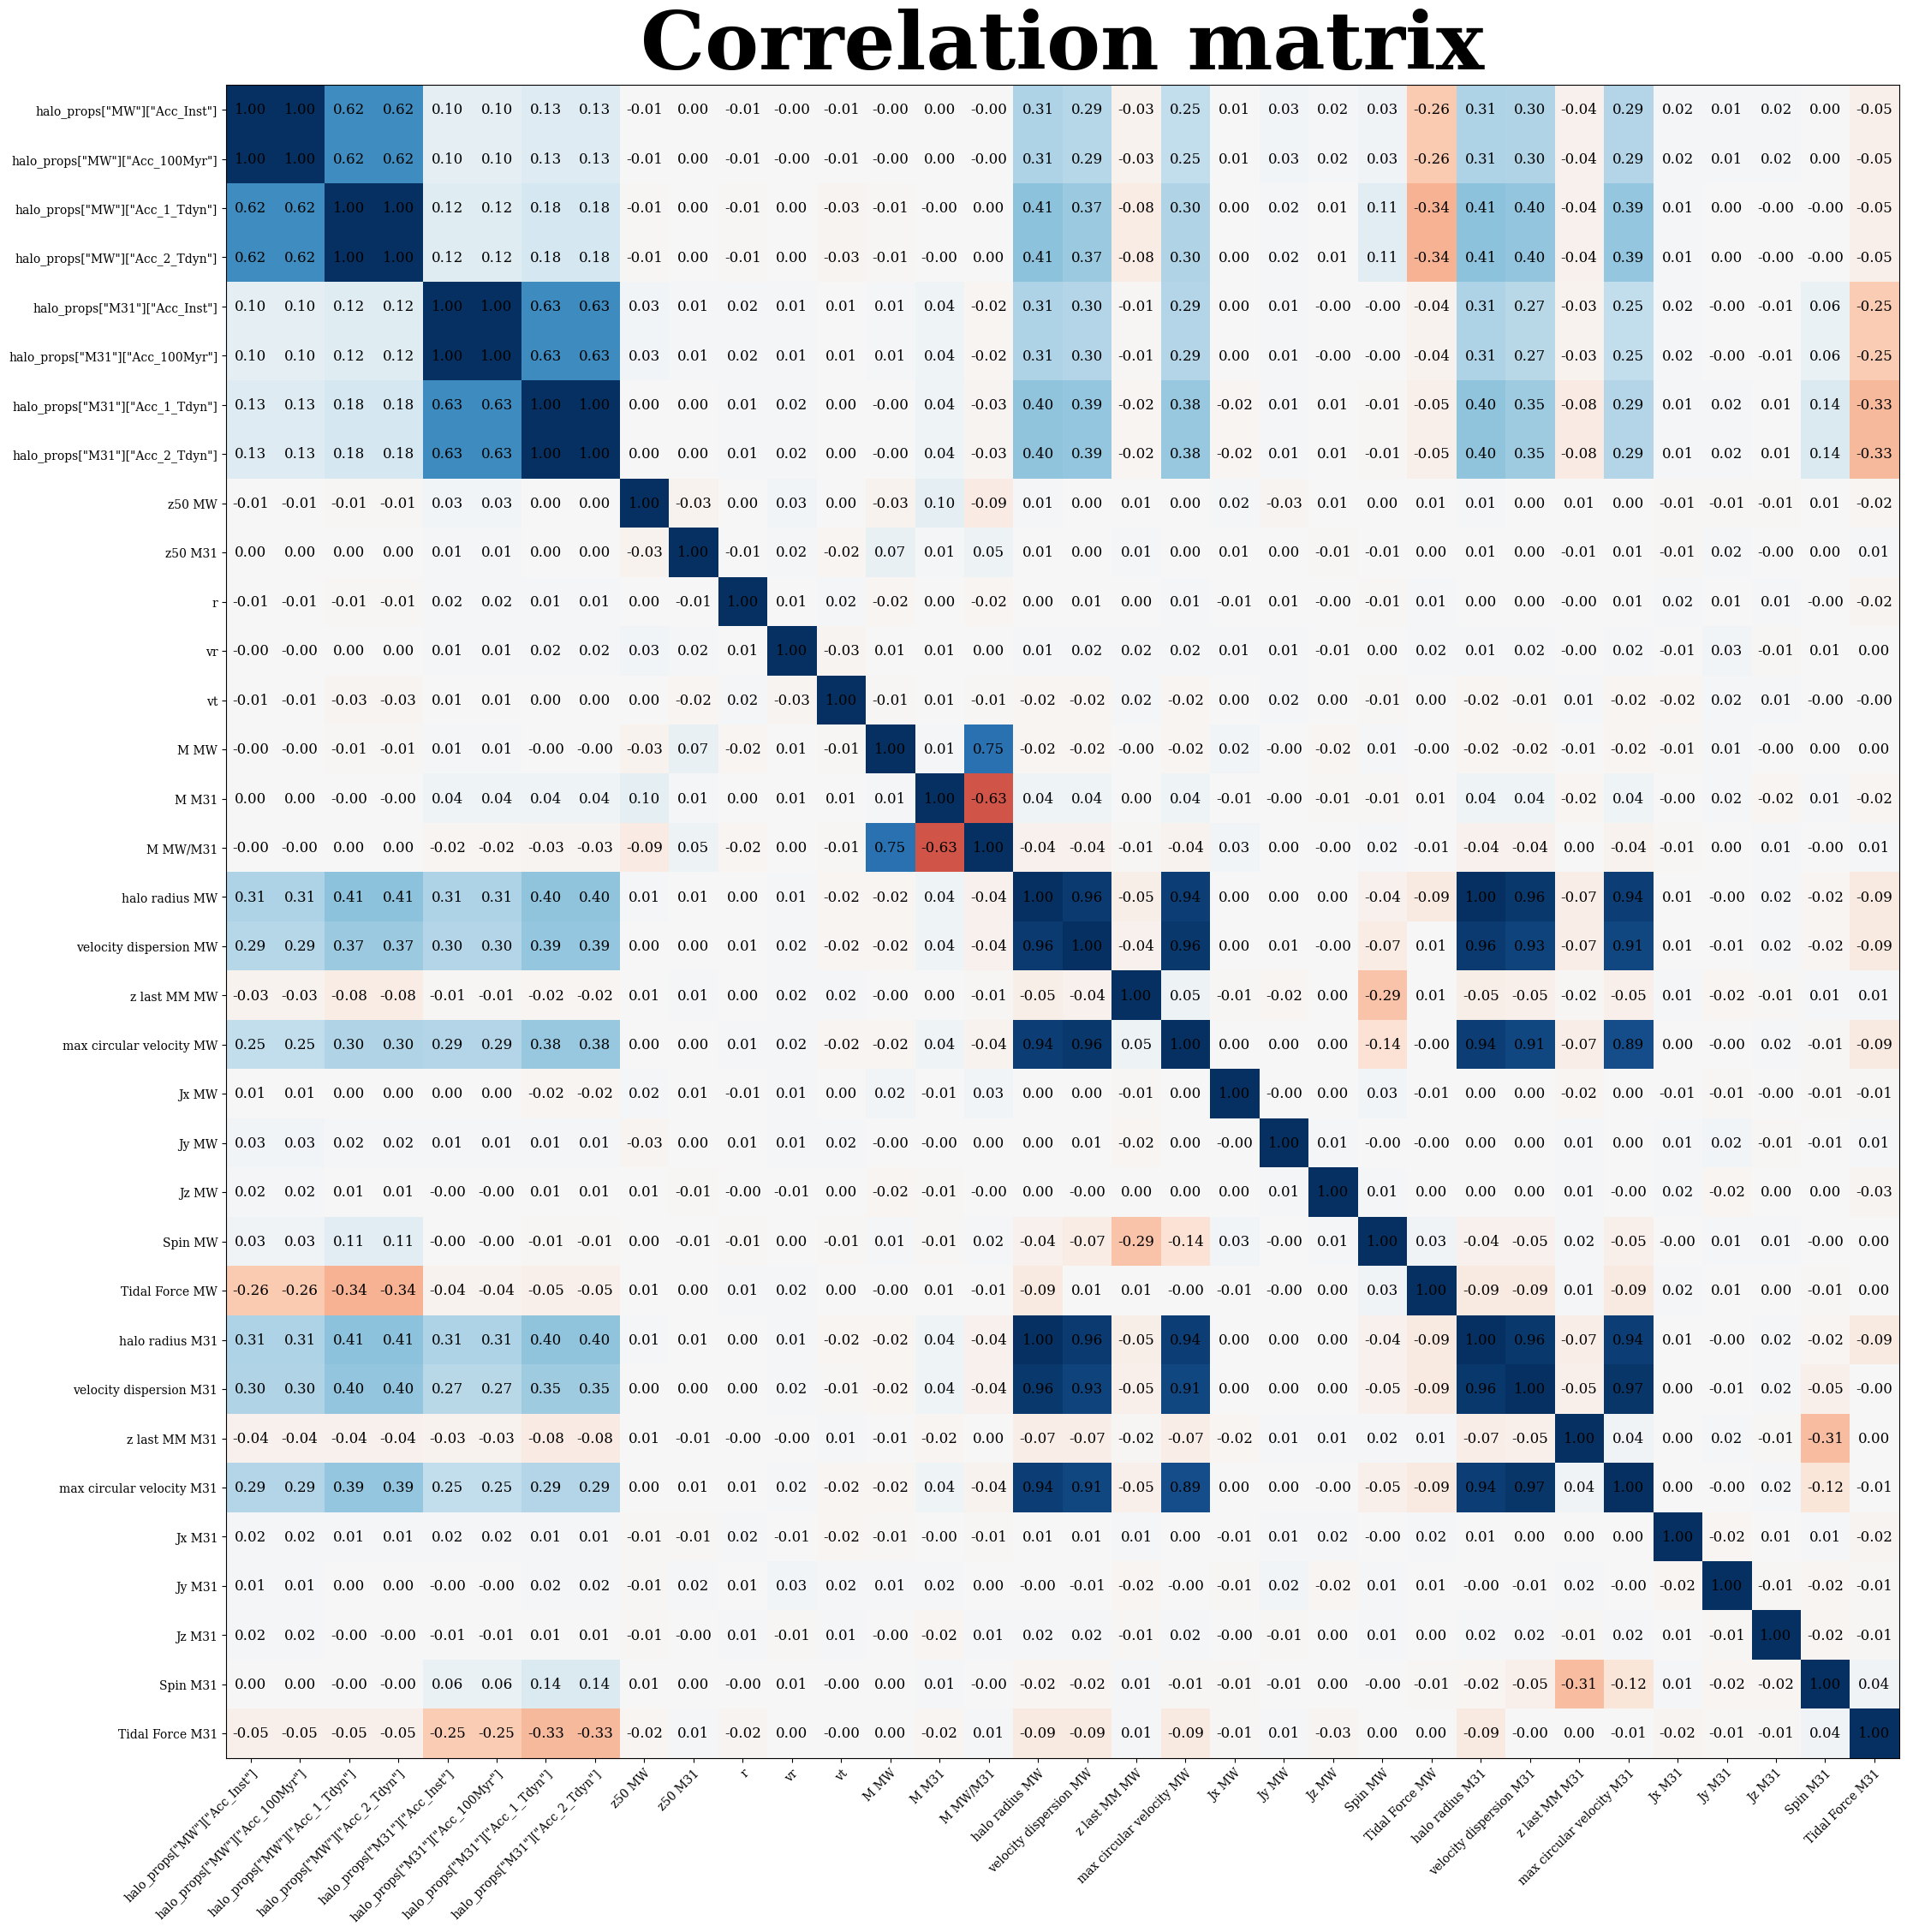

In [20]:
data = np.array([halo_props["MW"]["Acc_Inst"], halo_props["MW"]["Acc_100Myr"], halo_props["MW"]["Acc_1_Tdyn"], halo_props["MW"]["Acc_2_Tdyn"], halo_props["M31"]["Acc_Inst"], halo_props["M31"]["Acc_100Myr"], halo_props["M31"]["Acc_1_Tdyn"], halo_props["M31"]["Acc_2_Tdyn"], z50_MW_LG, z50_M31_LG, z0_data["r"], z0_data["vr"], z0_data["vt"], z0_data["M_MW"], z0_data["M_M31"], ratio_MW_over_M31, halo_props["MW"]["halo_radius"], halo_props["MW"]["velocity_disp"], z_last_MM_MW, halo_props["MW"]["max_circular_velocity"], halo_props["MW"]["Jx"], halo_props["MW"]["Jy"], halo_props["MW"]["Jz"], halo_props["MW"]["Spin"], halo_props["MW"]["Tidal_Force"], halo_props["M31"]["halo_radius"], halo_props["M31"]["velocity_disp"], z_last_MM_M31, halo_props["M31"]["max_circular_velocity"], halo_props["M31"]["Jx"], halo_props["M31"]["Jy"], halo_props["M31"]["Jz"], halo_props["M31"]["Spin"], halo_props["M31"]["Tidal_Force"]])
labels = ['halo_props["MW"]["Acc_Inst"]', 'halo_props["MW"]["Acc_100Myr"]', 'halo_props["MW"]["Acc_1_Tdyn"]', 'halo_props["MW"]["Acc_2_Tdyn"]', 'halo_props["M31"]["Acc_Inst"]', 'halo_props["M31"]["Acc_100Myr"]', 'halo_props["M31"]["Acc_1_Tdyn"]', 'halo_props["M31"]["Acc_2_Tdyn"]', "z50 MW",  "z50 M31", "r", "vr", "vt", "M MW", "M M31", "M MW/M31", "halo radius MW", "velocity dispersion MW", "z last MM MW", "max circular velocity MW", "Jx MW", "Jy MW", "Jz MW", "Spin MW", "Tidal Force MW", "halo radius M31", "velocity dispersion M31", "z last MM M31", "max circular velocity M31", "Jx M31", "Jy M31", "Jz M31", "Spin M31", "Tidal Force M31"]

# density_bar_0p3_0p7, density_bar_1_2p5, density_bar_5_10, density_bar_10_20, density_MW_0p3_0p7, density_MW_1_2p5, density_MW_5_10, density_MW_10_20, density_M31_0p3_0p7, density_M31_1_2p5, density_M31_5_10, density_M31_10_20, 
# "Density bar 0.3-0.7Mpc", "Density bar 1-2.5Mpc", "Density bar 5-10Mpc", "Density bar 10-20Mpc", "Density MW 0.3-0.7Mpc", "Density MW 1-2.5Mpc", "Density MW 5-10Mpc", "Density MW 10-20Mpc", "Density M31 0.3-0.7Mpc", "Density M31 1-2.5Mpc", "Density M31 5-10Mpc", "Density M31 10-20Mpc", 

save_file = "Correlation matrix.png"
plot_correlation_matrix(data, labels=labels, save_file=save_file)

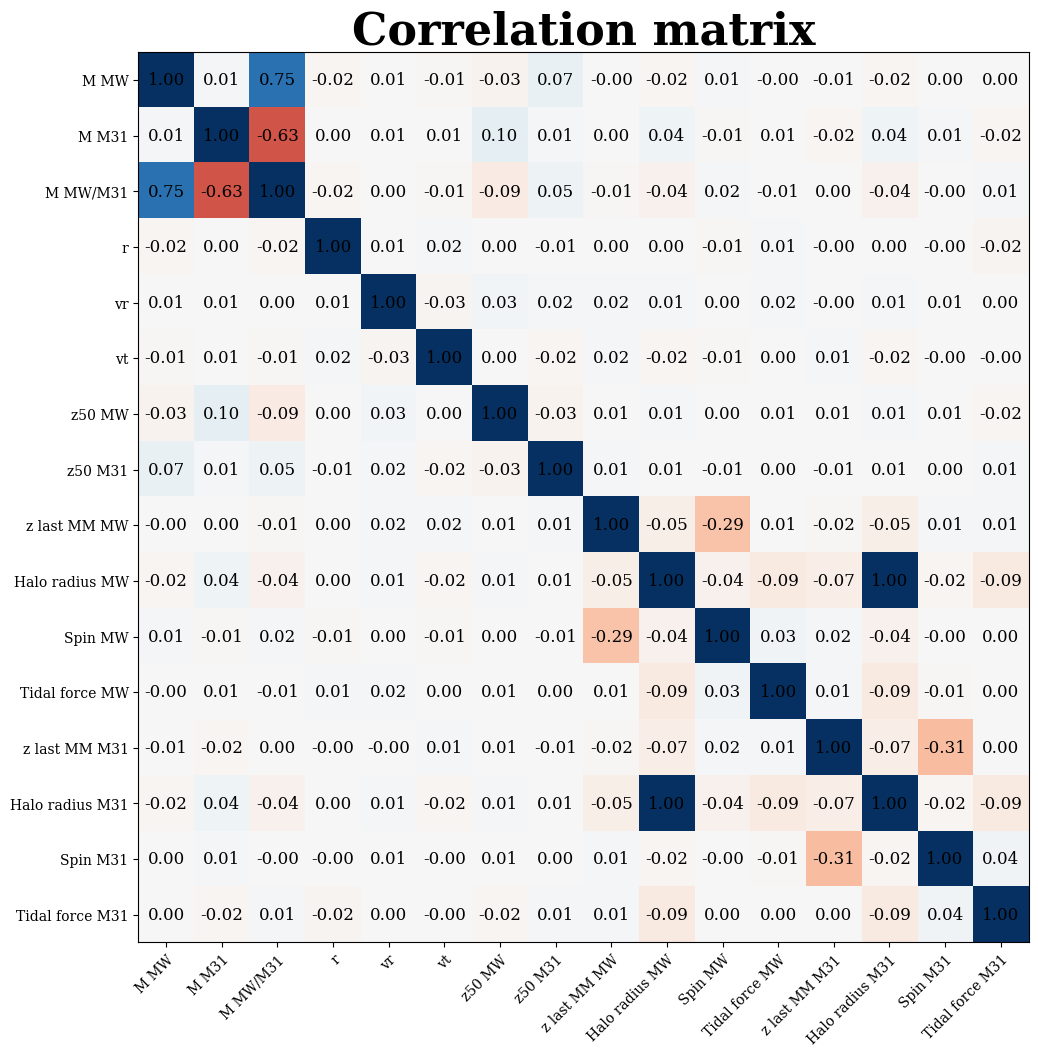

In [22]:
data = np.array([z0_data["M_MW"], z0_data["M_M31"], ratio_MW_over_M31, z0_data["r"], z0_data["vr"], z0_data["vt"], z50_MW_LG, z50_M31_LG, z_last_MM_MW, halo_props["MW"]["halo_radius"], halo_props["MW"]["Spin"], halo_props["MW"]["Tidal_Force"], z_last_MM_M31, halo_props["M31"]["halo_radius"], halo_props["M31"]["Spin"], halo_props["M31"]["Tidal_Force"]])
labels = ["M MW", "M M31", "M MW/M31", "r", "vr", "vt", "z50 MW",  "z50 M31", "z last MM MW", "Halo radius MW", "Spin MW", "Tidal force MW", "z last MM M31", "Halo radius M31", "Spin M31", "Tidal force M31"]

# density_bar_0p3_0p7, density_bar_1_2p5, density_bar_5_10, density_bar_10_20, density_MW_0p3_0p7, density_MW_1_2p5, density_MW_5_10, density_MW_10_20, density_M31_0p3_0p7, density_M31_1_2p5, density_M31_5_10, density_M31_10_20, 
# "Density bar 0.3-0.7Mpc", "Density bar 1-2.5Mpc", "Density bar 5-10Mpc", "Density bar 10-20Mpc", "Density MW 0.3-0.7Mpc", "Density MW 1-2.5Mpc", "Density MW 5-10Mpc", "Density MW 10-20Mpc", "Density M31 0.3-0.7Mpc", "Density M31 1-2.5Mpc", "Density M31 5-10Mpc", "Density M31 10-20Mpc", 

save_file = "Correlation matrix small.png"
plot_correlation_matrix(data, labels=labels, save_file=save_file)

### Covariance matrix + scatter for several pairs of variables

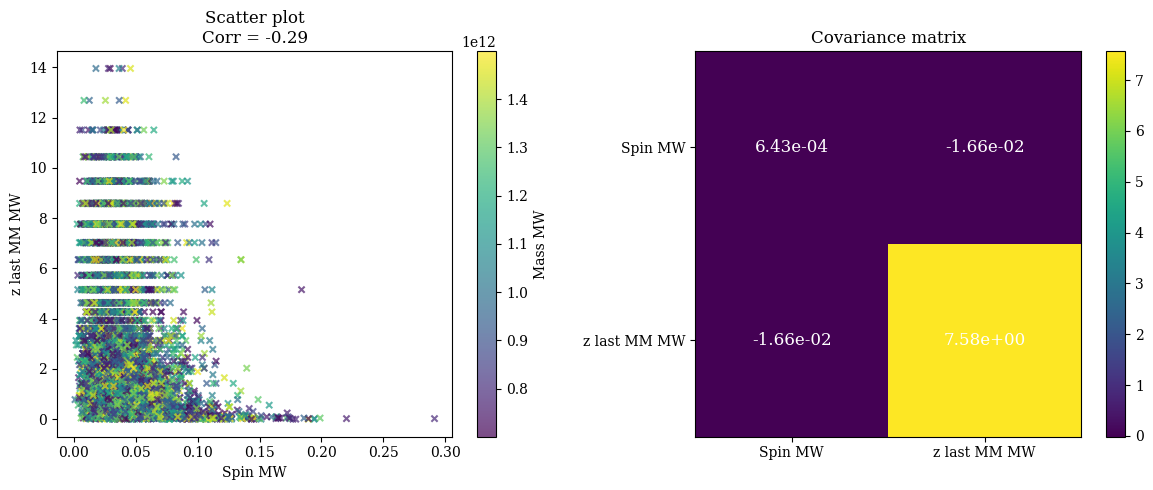

/tmp/erwannqu/28075093/ipykernel_1336689/1034606413.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax_scatter.scatter(data1, data2, c=data3 if data3 is not None else 'darkolivegreen', cmap='viridis', alpha=0.7, marker='x', s=20)


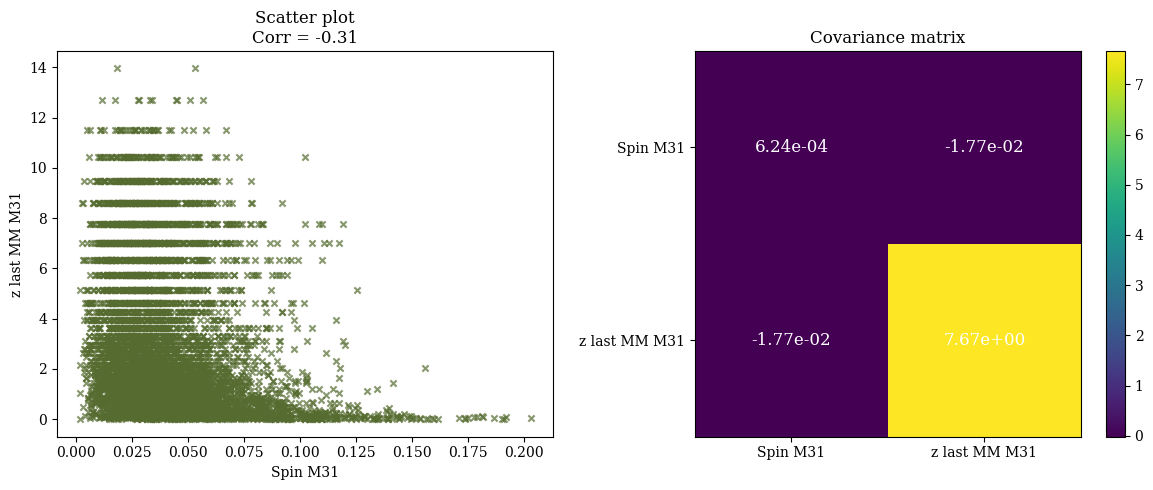

In [59]:




#scatter_and_covariance(ratio_MW_over_TA, ratio_M31_over_TA, labels=["M MW/TA", "M M31/TA"])
#scatter_and_covariance(ratio_M31_over_TA, z0_data["M_M31"], labels=["M M31/TA", "M M31"])
#scatter_and_covariance(ratio_MW_over_M31, z0_data["M_M31"], labels=["M MW/M31", "M M31"])
#scatter_and_covariance(z0_data["M_MW"], z0_data["M_M31"], labels=["M MW", "M M31"])

#scatter_and_covariance(halo_props["M31"]["Jy"], z50_MW_LG, labels=["Jy M31", "z50 MW"])

scatter_and_covariance(halo_props["MW"]["Spin"], z_last_MM_MW, z0_data["M_MW"], labels=["Spin MW", "z last MM MW", "Mass MW"])
#scatter_and_covariance(z0_data["M_MW"], z_last_MM_MW, labels=["M MW", "z last MM MW"])

scatter_and_covariance(halo_props["M31"]["Spin"], z_last_MM_M31, labels=["Spin M31", "z last MM M31"])
#scatter_and_covariance(z0_data["M_M31"], z_last_MM_M31, labels=["M M31", "z last MM M13"])


### Corner Plot

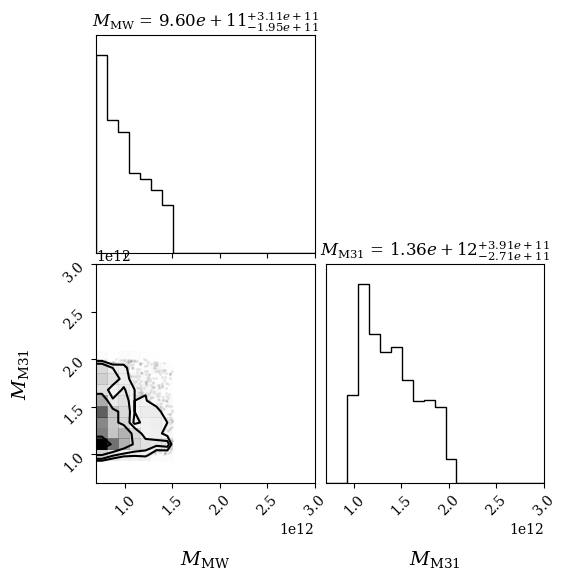

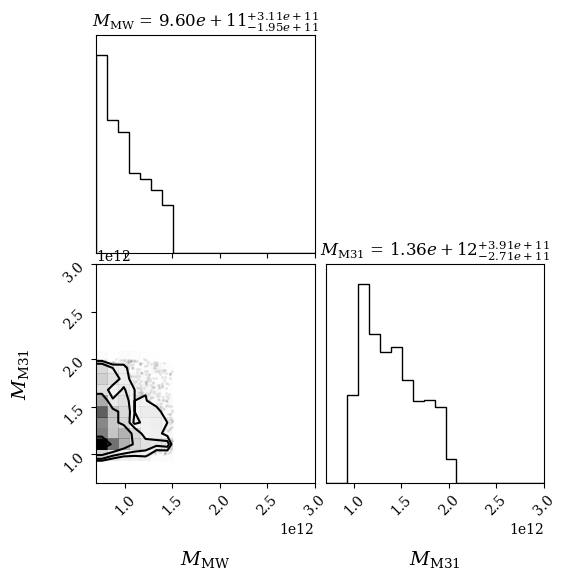

In [60]:
mw = mass_data["no_LG"]["MW"]["m"][:, 0]
m31 = mass_data["no_LG"]["M31"]["m"][:, 0]

min_len = min(len(mw), len(m31))  # on prend la longueur minimale

arrays = [mw[:min_len], m31[:min_len]]
data = np.vstack(arrays).T
labels = [r"$M_{\mathrm{MW}}$", r"$M_{\mathrm{M31}}$"]

fig = plt.figure(figsize=(6, 6))  # ou (8,8) pour plus grand
corner.corner(
    data,
    labels=labels,
    show_titles=True,
    title_fmt=".2e",
    range=[(7e11, 3e12), (7e11, 3e12)],  # plages MW et M31
    fig=fig,
    hist_bin_factor=1,
    label_kwargs={"fontsize": 14},
    title_kwargs={"fontsize": 12}
)

In [61]:
print(min(z0_data['r']))

700.0223022207934


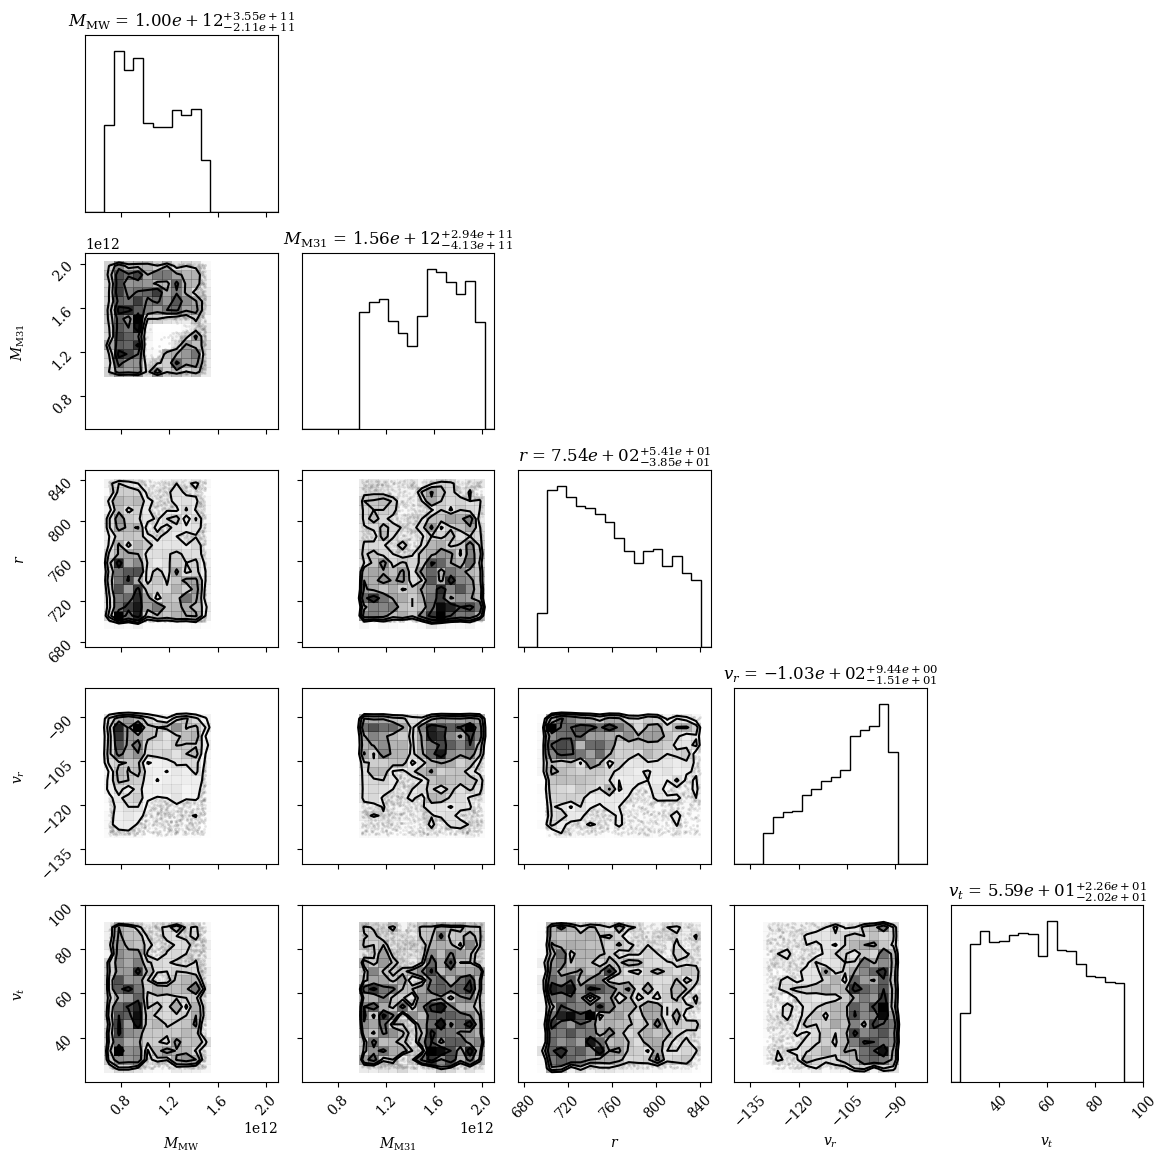

In [89]:
arrays = [mass_data["LG"]["MW"]["m"][:,0], mass_data["LG"]["M31"]["m"][:,0], z0_data["r"], z0_data["vr"], z0_data["vt"]]
data = np.vstack(arrays).T
labels = [r"$M_{\mathrm{MW}}$", r"$M_{\mathrm{M31}}$", r"$r$", r"$v_r$", r"$v_t$"]
data_range=[(5e11, 2.1e12), (5e11, 2.1e12), (675, 850), (-140, -80), (20, 100)]

import matplotlib.ticker as ticker

fig = corner.corner(data, labels=labels, show_titles=True, title_fmt=".2e", range=data_range)

fig.tight_layout()
fig.savefig("corner_plot_parameters.png")

### Histograms and parameters

In [64]:
def plot_histograms(variables, bin_widths, titles):
    """
    Plot some histograms in a figure
    
    Parameters:
      variables (dict): Dictionnary associating with each (str) key an (array) countaining the data to be ploted on the histograms ; ex : {"M_MW": z0_data["M_MW"], ...}.
      bandwidths (dict): Dictionnary indicating the bandwidth of each histogram ; ex : {"M_MW": 1e11, ...}.
      titles (dict): Dictionnary associating with each variable the label to be printed on the subplot ; ex : {"M_MW": r"$M_{\rm MW}$ [M$_\odot$]", ...}.
    """

    # We adapt the size of the grid depending on the number of subplots we want by approximating a square
    n = len(variables)
    nrows = int(np.floor(np.sqrt(n)))
    ncols = int(np.ceil(n/nrows))
    
    # Create the figure
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
    # Makes a 1D index
    if nrows * ncols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for i, key in enumerate(variables):
        data = np.array(variables[key])
        # Si la largeur de bande n'est pas spécifiée pour cette variable, on en choisit une par défaut (30 bins)
        bw = bin_widths.get(key, (np.max(data) - np.min(data)) / 30)
        bins = np.arange(np.min(data), np.max(data) + bw, bw)
        
        axes[i].hist(data, bins=bins, color='cadetblue', edgecolor='black', alpha=0.7)
        axes[i].set_title(titles.get(key, key))
        axes[i].set_xlabel(key)
        axes[i].set_ylabel("Number")
    
    # Hide the empty axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
        
    plt.tight_layout()
    plt.show()

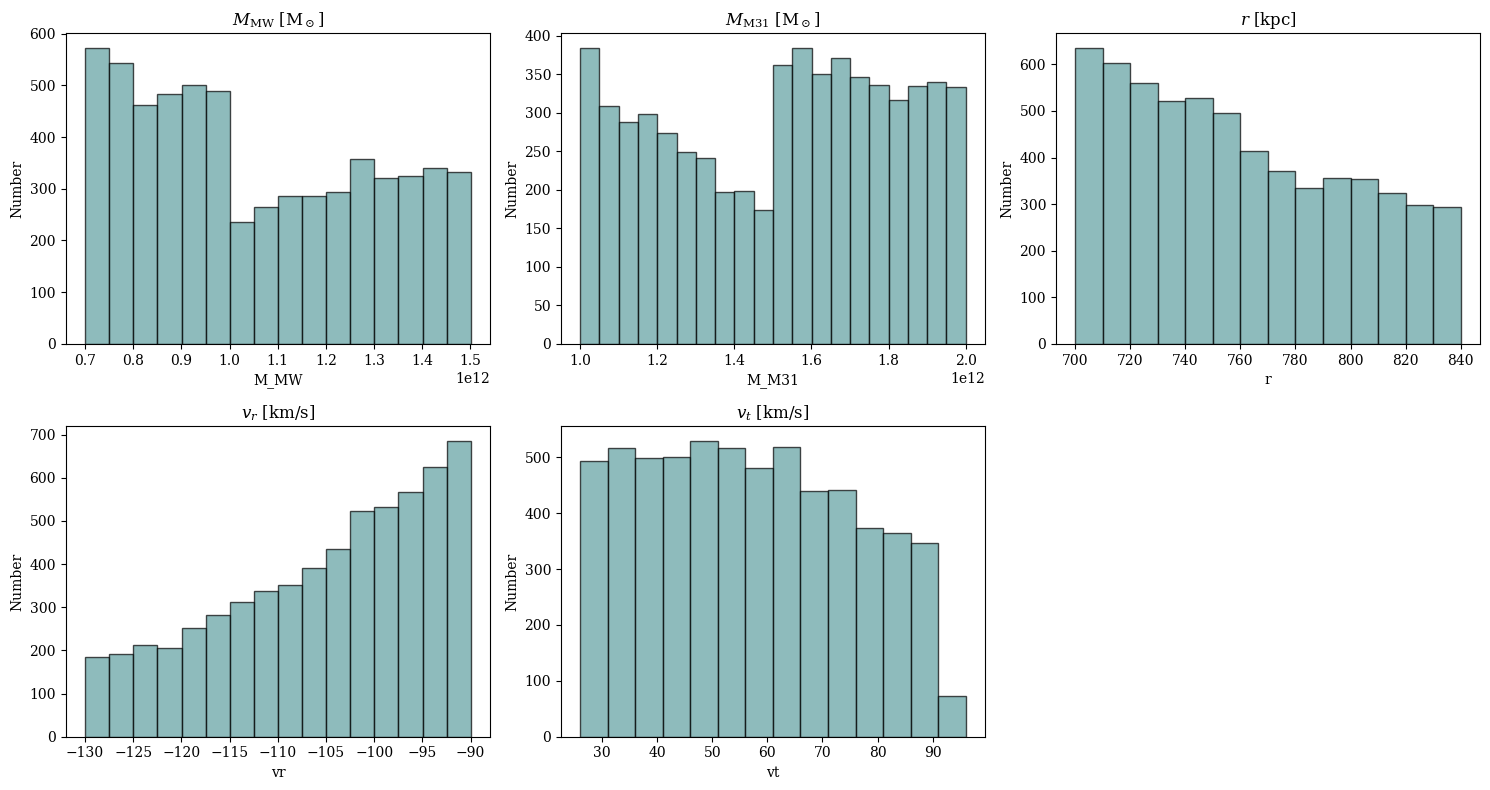

In [67]:
variables = {"M_MW": z0_data["M_MW"], "M_M31": z0_data["M_M31"], "r":    z0_data["r"], "vr":   z0_data["vr"], "vt":   z0_data["vt"]}
bin_widths = {"M_MW": 5e10, "M_M31": 5e10, "r": 10, "vr": 2.5, "vt": 5}

titles = {"M_MW": r"$M_{\rm MW}$ [M$_\odot$]",
          "M_M31": r"$M_{\rm M31}$ [M$_\odot$]",
          "r": r"$r$ [kpc]",
          "vr": r"$v_r$ [km/s]",
          "vt": r"$v_t$ [km/s]"}

plot_histograms(variables, bin_widths, titles)

For N = 6089, alpha = 0.05, the correlation is significant if p < -0.03 or p > 0.02


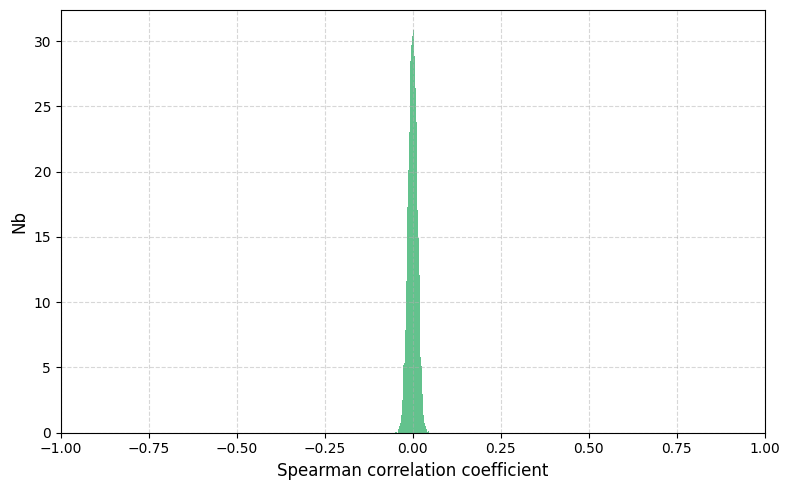

In [1]:
Num_Elements = 6089
Num_Repeats = 10000
alpha = 0.05

corrs = []

for _ in range(Num_Repeats):
    x1 = [random.uniform(0,1) for _ in range(Num_Elements)]
    x2 = [random.uniform(0,1) for _ in range(Num_Elements)]
    
    corr, _ = spearmanr(x1, x2)
    corrs.append(corr)

# Convert to numpy array for convenience
corrs = np.array(corrs)

lower = np.percentile(corrs, 100 * alpha / 2)
upper = np.percentile(corrs, 100 * (1 - alpha / 2))

print(f"For N = {Num_Elements}, alpha = {alpha}, the correlation is significant if p < {lower:.2f} or p > {upper:.2f}")


# Plot the density of Spearman coefficients
plt.figure(figsize=(8,5))
plt.hist(corrs, bins=50, density=True, color="mediumseagreen", alpha=0.8)
# plt.title("Distribution of Spearman correlation coefficients for two random variables of 6089 elements", fontsize=14)
plt.xlabel("Spearman correlation coefficient", fontsize=12)
plt.ylabel("Nb", fontsize=12)
plt.xlim(-1,1)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

For N = 159, alpha = 0.05, the correlation is significant if p < -0.16 or p > 0.16


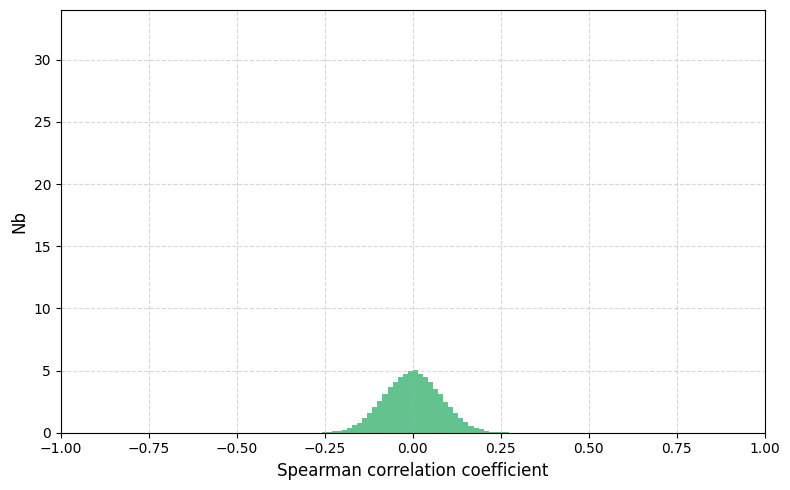

In [2]:
Num_Elements = 159
Num_Repeats = 100000
alpha = 0.05

corrs = []

for _ in range(Num_Repeats):
    x1 = [random.uniform(0,1) for _ in range(Num_Elements)]
    x2 = [random.uniform(0,1) for _ in range(Num_Elements)]
    
    corr, _ = spearmanr(x1, x2)
    corrs.append(corr)

# Convert to numpy array for convenience
corrs = np.array(corrs)

lower = np.percentile(corrs, 100 * alpha / 2)
upper = np.percentile(corrs, 100 * (1 - alpha / 2))

print(f"For N = {Num_Elements}, alpha = {alpha}, the correlation is significant if p < {lower:.2f} or p > {upper:.2f}")


# Plot the density of Spearman coefficients
plt.figure(figsize=(8,5))
plt.hist(corrs, bins=50, density=True, color="mediumseagreen", alpha=0.8)
# plt.title("Distribution of Spearman correlation coefficients for two random variables of 159 elements", fontsize=14)
plt.xlabel("Spearman correlation coefficient", fontsize=12)
plt.ylabel("Nb", fontsize=12)
plt.xlim(-1,1)
plt.ylim(0,34)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()